In [1]:
import os, fnmatch, copy, math
import numpy as np
from gudhi import CubicalComplex as CC
from gudhi import plot_persistence_barcode as plt_bar
from sklearn.preprocessing import MinMaxScaler

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

import copy
import matplotlib.pyplot as plt
from itertools import cycle

import pandas as pd
import math
import os

import image_perturbation as impt
import glob
import datetime
import itertools


'''
i: ith bar
n: number of bars
d: d-dimensional bars
x_i: left end pt of ith bar
y_i: right end pt of ith bar

15 total features x 2 dimensions (0 and 1), 30 features will be computed
'''
def f_1(diag):
	return sum( diag[:,1] * (diag[:,2] - diag[:,1]) ) / len(diag)

def f_2(diag):
	return sum( (diag[:,2].max() - diag[:,2]) * (diag[:,2] - diag[:,1]) )/ len(diag)

def f_3(diag):
	return sum( pow(diag[:,1],2) * pow( (diag[:,2] - diag[:,1]) ,4) )/ len(diag)

def f_4(diag):
	return sum( pow( (diag[:,2].max() - diag[:,2] ), 2) * pow( (diag[:,2] - diag[:,1]), 4) )/ len(diag)

def g_1(diag):
	return diag[:,1].mean()

def g_2(diag):
	return diag[:,2].mean()

def g_3(diag):
	return ( diag[:,2].max() - diag[:,2] ).mean()

def g_4(diag):
	return ( diag[:,2] - diag[:,1] ).mean()

def g_5(diag):
	return np.median(diag[:,1])

def g_6(diag):
	return np.median(diag[:,2])

def g_7(diag):
	return np.median(diag[:,2].max() - diag[:,2])

def g_8(diag):
	return np.median(diag[:,2] - diag[:,1])

def g_9(diag):
	return diag[:,1].std()

def g_10(diag):
	return diag[:,2].std()

def g_11(diag):
	return (diag[:,2] - diag[:,1]).std()
import file_structure
study= 'TDA'
(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs(study)

# only analyze in Z direction
#dir_list = [train_dir, val_dir, test_dir]

# modalities to consider
modal_list = [ 'FLAIR', 'T1', 'T1post', 'T2']

NA = 1000. # value that will be used as outside of ROI
lim = 1.1


In [14]:
modal_list = ['FLAIR', 'T2', 'T1', 'T1post']
feature_names = ['polynomial_1',
                 'polynomial_2', 
                 'polynomial_3', 
                 'polynomial_4',
                 'mean(birth)', 
                 'mean(death)', 
                 'mean(death_max-death)',
                 'mean(bar length)',
                 'median(birth)', 
                 'median(death)', 
                 'median(death_max-death)',
                 'median(bar length)',
                 'std(birth)', 
                 'std(death)', 
                 'std(bar length)']
level_list = ['0', '1']

feature_names_level = []
feature_names_all =[]

for level in level_list:
	feature_names_level.append([elemt + '_'+ level for elemt in feature_names])

feature_names_level = [val for sublist in feature_names_level for val in sublist]

# instantiate min-max scaler
scaler = MinMaxScaler(feature_range=(1,2))

mask_axial = np.load(find('*mask.npy', splitdir)[0])[:,:,:,2]
# case = 'C'
case_tau = {'R' : np.arange(-13,13+1,1),'N':np.arange(1,30+1,1),'T':[p for p in itertools.product([0,1/3,2/3], repeat=2)],
           'V': np.arange(-.28,.28+.2,.02),'C': np.arange(1,30+1,1)}
cases = list(case_tau.keys())

[dim_z, dim_x, dim_y] = mask_axial.shape
dir_type = os.path.basename(splitdir)
save_str = os.path.join(splitdir, 'slices_persistent_homology.npy')

print('computing dataset: ', 'slices')
mask = np.load(os.path.join(splitdir,'slices_exp_mask.npy'))
img = {}
n_features = 2 * 15 #n_dim * 15 features per dim

for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_exp_%s.npy' % (modal)))
    
[dim_z, dim_x, dim_y] = mask[:,:,:,2].shape
diag_dict ={}
for modal in modal_list:
    diag_dict[modal] = {}

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]
    
#     slice_ind = 25
#     if 1:
    for case in cases:
        diag_dict[modal][case] = {}
        tau_vec = case_tau[case]

        for adi in range(len(tau_vec)):
#             print('%s - %d - %f' % (modal,slice_ind,tau))
            diag_dict[modal][case][adi] =[]

            tau = tau_vec[adi]

            for slice_ind in range(n_slices):
                if (slice_ind % 10) == 0:
                    print('%s %s - %d,%d' % (modal,case,adi,slice_ind), datetime.datetime.now().time())

                # for view_ind in range(len(views)):
                    # pick slice and view
                img_slice = img[modal][slice_ind,:,:,2]
                mask_slice = (mask[slice_ind,:,:,2] > 0) * 1
                if case == 'R':
                    adj_mask = impt.rotate_image(mask_slice,tau,mask_slice)
                    adj_slice = impt.rotate_image(img_slice,tau,mask_slice)
                elif case == 'N':
                    np.random.seed(tau)
                    adj_slice = impt.add_noise(img_slice,reps=1)
                    adj_mask = mask_slice.copy()
                elif case == 'T':
                    adj_slice = impt.translate_image(img_slice,shift=tau)
                    adj_mask = impt.translate_image(mask_slice,shift=tau)
                elif case == 'V':
                    adj_slice = img_slice.copy()
                    adj_mask = impt.grow_shrink_image(mask_slice,tau)
                elif case == 'C':
                    np.random.seed(tau)
                    adj_slice = img_slice.copy()
                    adj_mask = impt.adjust_image_contour(img_slice,mask_slice)

                slice_copy = copy.deepcopy(adj_slice)
                slice_copy[adj_mask.nonzero()] = scaler.fit_transform(slice_copy[adj_mask.nonzero()].reshape(-1,1)).reshape(-1)
                slice_copy[np.where(adj_mask ==0)] = NA

                flipped = np.flipud(slice_copy)
                flattened = flipped.reshape(-1)
                cell_list = flattened.tolist()

                # compute persistence
                CC_instance = CC(dimensions= [dim_x, dim_y], top_dimensional_cells = cell_list)
                diag = CC_instance.persistence()

                # convert diag into numpy array for later analysis
                filtered = list()

                for elmt_ind in range(len(diag)):
                    elmt = diag[elmt_ind]
                    if elmt[1][1] != NA:
                        if elmt[1][1] == math.inf:
                            filtered.append( [elmt[0], elmt[1][0], lim] )
                        else:
                            filtered.append( [elmt[0], elmt[1][0], elmt[1][1]] )

                filtered = np.reshape(filtered,[-1,3])
                diag_dict[modal][case][adi].append(filtered)


# n_data = len(diag_dict['T1'])
feature_mat = np.zeros([len(modal_list),n_slices,n_features,len(cases), 38])
for mIdx in range(len(modal_list)):
    feature_modal = 
    modal = modal_list[mIdx]
    for cIdx in range(len(cases)):
        case = cases[cIdx]
        tau_vec = case_tau[case]
        for adi in range(len(tau_vec)):
            print('%s %s - %d' % (modal,case,adi), datetime.datetime.now().time())
            for image_ind in range(len(diag_dict[modal])):
                feature_vec = list()
                diag = diag_dict[modal][case][adi][image_ind]
                #diag = np.asarray(ph_data[modal][image_ind])
                #print(diag)
                #print(diag[:,0])
                diag_list =[diag[np.where(diag[:,0]==0)], diag[np.where(diag[:,0]==1)]]

                for diag_elmt in diag_list:
                    feature_vec.append( [f_1(diag_elmt), f_2(diag_elmt), f_3(diag_elmt), f_4(diag_elmt),
                                    g_1(diag_elmt), g_2(diag_elmt), g_3(diag_elmt), g_4(diag_elmt),
                                    g_5(diag_elmt), g_6(diag_elmt), g_7(diag_elmt), g_8(diag_elmt),
                                    g_9(diag_elmt), g_10(diag_elmt), g_11(diag_elmt)] )

                flat_feature_vec = [item for sublist in feature_vec for item in sublist]
                feature_mat[mIdx,image_ind,cIdx,adi,:] = flat_feature_vec

#     feature_mat.append(feature_modal)

# features = np.hstack((feature_mat[0], feature_mat[1],feature_mat[2], feature_mat[3]))

# data_frame = pd.DataFrame(data=features, columns = feature_names_all_flattened)

# save
#data_frame.to_csv(save_str[ph_ind] + '.csv')
# data_frame.to_csv(os.path.join(splitdir,save_str + '.csv'))
samples = np.concatenate((feature_mat[0], feature_mat[1],feature_mat[2], feature_mat[3]),axis = 3)

np.save(os.path.join(splitdir,'slices_TDA_ptb_mat.npy'), feature_mat)
import pickle
f = open("os.path.join(splitdir,'slices_TDA_ptb.pkl","wb")
pickle.dump(diag_dict,f)
f.close()

# np.save(os.path.join(splitdir,'TDA_feature_names.npy'), feature_names_all_flattened)

computing dataset:  slices
FLAIR R - 0,0 13:29:23.079799
FLAIR R - 0,10 13:29:32.114769
FLAIR R - 0,20 13:29:40.771737
FLAIR R - 0,30 13:29:49.422687
FLAIR R - 0,40 13:29:57.905192
FLAIR R - 0,50 13:30:06.485957
FLAIR R - 0,60 13:30:14.325756
FLAIR R - 0,70 13:30:19.906562
FLAIR R - 0,80 13:30:26.596311
FLAIR R - 0,90 13:30:34.935435
FLAIR R - 0,100 13:30:43.788924
FLAIR R - 0,110 13:30:52.602306
FLAIR R - 0,120 13:31:01.749574
FLAIR R - 0,130 13:31:10.573037
FLAIR R - 0,140 13:31:19.206997
FLAIR R - 0,150 13:31:28.247038
FLAIR R - 0,160 13:31:37.134672
FLAIR R - 0,170 13:31:46.285005
FLAIR R - 0,180 13:31:53.385923
FLAIR R - 0,190 13:31:58.161625
FLAIR R - 0,200 13:32:03.319338
FLAIR R - 0,210 13:32:08.030862
FLAIR R - 0,220 13:32:12.822577
FLAIR R - 0,230 13:32:17.594267
FLAIR R - 0,240 13:32:22.277721
FLAIR R - 0,250 13:32:26.915052
FLAIR R - 0,260 13:32:31.502279
FLAIR R - 0,270 13:32:36.129557
FLAIR R - 0,280 13:32:40.749871
FLAIR R - 0,290 13:32:45.217725
FLAIR R - 0,300 13:32:49

FLAIR R - 4,490 13:56:32.153627
FLAIR R - 4,500 13:56:36.745999
FLAIR R - 4,510 13:56:41.393713
FLAIR R - 5,0 13:56:46.014826
FLAIR R - 5,10 13:56:50.682522
FLAIR R - 5,20 13:56:55.351296
FLAIR R - 5,30 13:56:59.964060
FLAIR R - 5,40 13:57:04.709136
FLAIR R - 5,50 13:57:09.545339
FLAIR R - 5,60 13:57:14.424859
FLAIR R - 5,70 13:57:19.330400
FLAIR R - 5,80 13:57:24.138461
FLAIR R - 5,90 13:57:28.971187
FLAIR R - 5,100 13:57:34.045292
FLAIR R - 5,110 13:57:39.269252
FLAIR R - 5,120 13:57:44.380905
FLAIR R - 5,130 13:57:49.689443
FLAIR R - 5,140 13:57:54.866080
FLAIR R - 5,150 13:57:59.949525
FLAIR R - 5,160 13:58:04.876614
FLAIR R - 5,170 13:58:09.822634
FLAIR R - 5,180 13:58:14.570750
FLAIR R - 5,190 13:58:19.214424
FLAIR R - 5,200 13:58:23.916928
FLAIR R - 5,210 13:58:28.621203
FLAIR R - 5,220 13:58:34.505166
FLAIR R - 5,230 13:58:40.998051
FLAIR R - 5,240 13:58:49.685967
FLAIR R - 5,250 13:58:58.307460
FLAIR R - 5,260 13:59:07.015588
FLAIR R - 5,270 13:59:15.638008
FLAIR R - 5,280 13:

FLAIR R - 9,470 14:27:27.445797
FLAIR R - 9,480 14:27:35.982445
FLAIR R - 9,490 14:27:44.606325
FLAIR R - 9,500 14:27:53.231207
FLAIR R - 9,510 14:28:01.943321
FLAIR R - 10,0 14:28:09.403112
FLAIR R - 10,10 14:28:17.090509
FLAIR R - 10,20 14:28:25.852753
FLAIR R - 10,30 14:28:34.592942
FLAIR R - 10,40 14:28:43.374239
FLAIR R - 10,50 14:28:52.201659
FLAIR R - 10,60 14:29:01.034870
FLAIR R - 10,70 14:29:08.615984
FLAIR R - 10,80 14:29:14.152673
FLAIR R - 10,90 14:29:20.973769
FLAIR R - 10,100 14:29:29.778128
FLAIR R - 10,110 14:29:38.584491
FLAIR R - 10,120 14:29:47.280562
FLAIR R - 10,130 14:29:56.079907
FLAIR R - 10,140 14:30:05.049704
FLAIR R - 10,150 14:30:13.582342
FLAIR R - 10,160 14:30:22.486967
FLAIR R - 10,170 14:30:30.860181
FLAIR R - 10,180 14:30:39.523164
FLAIR R - 10,190 14:30:47.610620
FLAIR R - 10,200 14:30:56.405955
FLAIR R - 10,210 14:31:04.932577
FLAIR R - 10,220 14:31:14.915061
FLAIR R - 10,230 14:31:22.904256
FLAIR R - 10,240 14:31:28.102047
FLAIR R - 10,250 14:31:33.

FLAIR R - 14,380 15:01:24.141717
FLAIR R - 14,390 15:01:32.667335
FLAIR R - 14,400 15:01:41.057595
FLAIR R - 14,410 15:01:49.563161
FLAIR R - 14,420 15:01:58.509897
FLAIR R - 14,430 15:02:07.115729
FLAIR R - 14,440 15:02:15.878978
FLAIR R - 14,450 15:02:24.775581
FLAIR R - 14,460 15:02:33.724323
FLAIR R - 14,470 15:02:42.559764
FLAIR R - 14,480 15:02:51.302959
FLAIR R - 14,490 15:03:00.195552
FLAIR R - 14,500 15:03:08.944765
FLAIR R - 14,510 15:03:15.114160
FLAIR R - 15,0 15:03:21.072941
FLAIR R - 15,10 15:03:29.668746
FLAIR R - 15,20 15:03:38.508197
FLAIR R - 15,30 15:03:46.709957
FLAIR R - 15,40 15:03:55.123278
FLAIR R - 15,50 15:04:03.703041
FLAIR R - 15,60 15:04:11.569823
FLAIR R - 15,70 15:04:19.935901
FLAIR R - 15,80 15:04:28.324199
FLAIR R - 15,90 15:04:36.483748
FLAIR R - 15,100 15:04:44.038093
FLAIR R - 15,110 15:04:52.058538
FLAIR R - 15,120 15:05:00.924379
FLAIR R - 15,130 15:05:10.003666
FLAIR R - 15,140 15:05:18.964756
FLAIR R - 15,150 15:05:26.429742
FLAIR R - 15,160 15:0

FLAIR R - 19,280 15:35:15.243861
FLAIR R - 19,290 15:35:23.080608
FLAIR R - 19,300 15:35:28.761916
FLAIR R - 19,310 15:35:35.618720
FLAIR R - 19,320 15:35:43.559191
FLAIR R - 19,330 15:35:51.533441
FLAIR R - 19,340 15:36:00.089214
FLAIR R - 19,350 15:36:08.574801
FLAIR R - 19,360 15:36:17.185318
FLAIR R - 19,370 15:36:25.897597
FLAIR R - 19,380 15:36:33.620362
FLAIR R - 19,390 15:36:41.915138
FLAIR R - 19,400 15:36:49.544765
FLAIR R - 19,410 15:36:58.134656
FLAIR R - 19,420 15:37:07.081170
FLAIR R - 19,430 15:37:14.697255
FLAIR R - 19,440 15:37:23.561635
FLAIR R - 19,450 15:37:32.169783
FLAIR R - 19,460 15:37:39.716408
FLAIR R - 19,470 15:37:45.199720
FLAIR R - 19,480 15:37:52.944694
FLAIR R - 19,490 15:38:01.277927
FLAIR R - 19,500 15:38:09.392598
FLAIR R - 19,510 15:38:17.685435
FLAIR R - 20,0 15:38:25.555152
FLAIR R - 20,10 15:38:34.299148
FLAIR R - 20,20 15:38:43.112103
FLAIR R - 20,30 15:38:51.685263
FLAIR R - 20,40 15:39:00.106958
FLAIR R - 20,50 15:39:08.908672
FLAIR R - 20,60 1

FLAIR R - 24,180 16:00:32.876167
FLAIR R - 24,190 16:00:37.588475
FLAIR R - 24,200 16:00:42.446666
FLAIR R - 24,210 16:00:47.201699
FLAIR R - 24,220 16:00:51.924051
FLAIR R - 24,230 16:00:56.455790
FLAIR R - 24,240 16:01:01.030487
FLAIR R - 24,250 16:01:05.717547
FLAIR R - 24,260 16:01:10.437515
FLAIR R - 24,270 16:01:15.271032
FLAIR R - 24,280 16:01:20.032314
FLAIR R - 24,290 16:01:24.595161
FLAIR R - 24,300 16:01:29.241247
FLAIR R - 24,310 16:01:33.814631
FLAIR R - 24,320 16:01:38.358135
FLAIR R - 24,330 16:01:43.185348
FLAIR R - 24,340 16:01:48.029353
FLAIR R - 24,350 16:01:52.665347
FLAIR R - 24,360 16:01:57.374605
FLAIR R - 24,370 16:02:02.055581
FLAIR R - 24,380 16:02:06.915559
FLAIR R - 24,390 16:02:11.637402
FLAIR R - 24,400 16:02:16.363497
FLAIR R - 24,410 16:02:21.170091
FLAIR R - 24,420 16:02:26.011717
FLAIR R - 24,430 16:02:30.745531
FLAIR R - 24,440 16:02:35.564785
FLAIR R - 24,450 16:02:40.223075
FLAIR R - 24,460 16:02:44.915415
FLAIR R - 24,470 16:02:49.580548
FLAIR R - 

FLAIR N - 2,120 16:19:07.550554
FLAIR N - 2,130 16:19:11.544323
FLAIR N - 2,140 16:19:15.603695
FLAIR N - 2,150 16:19:19.509959
FLAIR N - 2,160 16:19:23.425493
FLAIR N - 2,170 16:19:27.426326
FLAIR N - 2,180 16:19:31.465629
FLAIR N - 2,190 16:19:35.469980
FLAIR N - 2,200 16:19:39.458482
FLAIR N - 2,210 16:19:43.473125
FLAIR N - 2,220 16:19:47.562973
FLAIR N - 2,230 16:19:51.513572
FLAIR N - 2,240 16:19:55.494532
FLAIR N - 2,250 16:19:59.355603
FLAIR N - 2,260 16:20:03.319155
FLAIR N - 2,270 16:20:07.276760
FLAIR N - 2,280 16:20:11.310275
FLAIR N - 2,290 16:20:15.142890
FLAIR N - 2,300 16:20:19.146935
FLAIR N - 2,310 16:20:23.099685
FLAIR N - 2,320 16:20:27.062707
FLAIR N - 2,330 16:20:31.200135
FLAIR N - 2,340 16:20:35.229144
FLAIR N - 2,350 16:20:39.299038
FLAIR N - 2,360 16:20:43.330744
FLAIR N - 2,370 16:20:47.498861
FLAIR N - 2,380 16:20:51.784382
FLAIR N - 2,390 16:20:56.252544
FLAIR N - 2,400 16:21:00.753007
FLAIR N - 2,410 16:21:05.024247
FLAIR N - 2,420 16:21:09.301035
FLAIR N 

FLAIR N - 7,100 16:41:47.733683
FLAIR N - 7,110 16:41:54.971281
FLAIR N - 7,120 16:42:02.282004
FLAIR N - 7,130 16:42:09.586793
FLAIR N - 7,140 16:42:16.768819
FLAIR N - 7,150 16:42:24.119737
FLAIR N - 7,160 16:42:31.373012
FLAIR N - 7,170 16:42:38.693197
FLAIR N - 7,180 16:42:45.814313
FLAIR N - 7,190 16:42:52.748636
FLAIR N - 7,200 16:43:00.010493
FLAIR N - 7,210 16:43:07.276988
FLAIR N - 7,220 16:43:14.657825
FLAIR N - 7,230 16:43:21.418274
FLAIR N - 7,240 16:43:26.803941
FLAIR N - 7,250 16:43:31.530111
FLAIR N - 7,260 16:43:38.103830
FLAIR N - 7,270 16:43:45.412068
FLAIR N - 7,280 16:43:52.016235
FLAIR N - 7,290 16:43:59.236329
FLAIR N - 7,300 16:44:06.177767
FLAIR N - 7,310 16:44:13.216656
FLAIR N - 7,320 16:44:20.295811
FLAIR N - 7,330 16:44:27.174614
FLAIR N - 7,340 16:44:34.394191
FLAIR N - 7,350 16:44:41.440263
FLAIR N - 7,360 16:44:48.520483
FLAIR N - 7,370 16:44:55.228829
FLAIR N - 7,380 16:45:01.897507
FLAIR N - 7,390 16:45:09.131376
FLAIR N - 7,400 16:45:16.417582
FLAIR N 

FLAIR N - 12,50 17:10:29.777058
FLAIR N - 12,60 17:10:36.203732
FLAIR N - 12,70 17:10:43.389334
FLAIR N - 12,80 17:10:49.901215
FLAIR N - 12,90 17:10:57.106749
FLAIR N - 12,100 17:11:03.991384
FLAIR N - 12,110 17:11:09.662164
FLAIR N - 12,120 17:11:14.162623
FLAIR N - 12,130 17:11:19.484970
FLAIR N - 12,140 17:11:26.048185
FLAIR N - 12,150 17:11:33.210459
FLAIR N - 12,160 17:11:40.427176
FLAIR N - 12,170 17:11:47.759292
FLAIR N - 12,180 17:11:54.613911
FLAIR N - 12,190 17:12:00.963548
FLAIR N - 12,200 17:12:08.124188
FLAIR N - 12,210 17:12:15.042822
FLAIR N - 12,220 17:12:22.444842
FLAIR N - 12,230 17:12:29.290462
FLAIR N - 12,240 17:12:36.370325
FLAIR N - 12,250 17:12:43.568259
FLAIR N - 12,260 17:12:50.725362
FLAIR N - 12,270 17:12:57.754573
FLAIR N - 12,280 17:13:04.603004
FLAIR N - 12,290 17:13:11.460745
FLAIR N - 12,300 17:13:17.811041
FLAIR N - 12,310 17:13:24.308408
FLAIR N - 12,320 17:13:29.379283
FLAIR N - 12,330 17:13:34.183369
FLAIR N - 12,340 17:13:40.630999
FLAIR N - 12,35

FLAIR N - 16,470 17:38:19.861618
FLAIR N - 16,480 17:38:24.306027
FLAIR N - 16,490 17:38:30.393708
FLAIR N - 16,500 17:38:36.885250
FLAIR N - 16,510 17:38:44.201673
FLAIR N - 17,0 17:38:50.466187
FLAIR N - 17,10 17:38:57.603681
FLAIR N - 17,20 17:39:04.644432
FLAIR N - 17,30 17:39:11.892348
FLAIR N - 17,40 17:39:18.411685
FLAIR N - 17,50 17:39:25.791890
FLAIR N - 17,60 17:39:33.086838
FLAIR N - 17,70 17:39:40.195021
FLAIR N - 17,80 17:39:47.484682
FLAIR N - 17,90 17:39:54.270974
FLAIR N - 17,100 17:40:01.160163
FLAIR N - 17,110 17:40:08.279249
FLAIR N - 17,120 17:40:15.176342
FLAIR N - 17,130 17:40:22.350178
FLAIR N - 17,140 17:40:28.697919
FLAIR N - 17,150 17:40:33.447646
FLAIR N - 17,160 17:40:38.294572
FLAIR N - 17,170 17:40:45.628047
FLAIR N - 17,180 17:40:52.651818
FLAIR N - 17,190 17:40:59.795704
FLAIR N - 17,200 17:41:06.068385
FLAIR N - 17,210 17:41:12.849112
FLAIR N - 17,220 17:41:20.033683
FLAIR N - 17,230 17:41:26.582877
FLAIR N - 17,240 17:41:33.605668
FLAIR N - 17,250 17:4

FLAIR N - 21,370 18:06:10.350326
FLAIR N - 21,380 18:06:17.526333
FLAIR N - 21,390 18:06:24.739358
FLAIR N - 21,400 18:06:31.706216
FLAIR N - 21,410 18:06:38.298228
FLAIR N - 21,420 18:06:45.788099
FLAIR N - 21,430 18:06:52.590306
FLAIR N - 21,440 18:07:00.090275
FLAIR N - 21,450 18:07:07.012347
FLAIR N - 21,460 18:07:14.184703
FLAIR N - 21,470 18:07:21.543226
FLAIR N - 21,480 18:07:28.780344
FLAIR N - 21,490 18:07:35.851931
FLAIR N - 21,500 18:07:41.943712
FLAIR N - 21,510 18:07:48.981371
FLAIR N - 22,0 18:07:55.655438
FLAIR N - 22,10 18:08:02.188410
FLAIR N - 22,20 18:08:06.738158
FLAIR N - 22,30 18:08:12.079788
FLAIR N - 22,40 18:08:18.953861
FLAIR N - 22,50 18:08:25.879407
FLAIR N - 22,60 18:08:32.708408
FLAIR N - 22,70 18:08:39.625752
FLAIR N - 22,80 18:08:46.662355
FLAIR N - 22,90 18:08:52.941619
FLAIR N - 22,100 18:09:00.331540
FLAIR N - 22,110 18:09:07.607777
FLAIR N - 22,120 18:09:14.842281
FLAIR N - 22,130 18:09:21.511839
FLAIR N - 22,140 18:09:28.930930
FLAIR N - 22,150 18:0

FLAIR N - 26,270 18:25:54.097642
FLAIR N - 26,280 18:25:57.958058
FLAIR N - 26,290 18:26:01.734544
FLAIR N - 26,300 18:26:05.536919
FLAIR N - 26,310 18:26:09.359773
FLAIR N - 26,320 18:26:13.128469
FLAIR N - 26,330 18:26:17.094986
FLAIR N - 26,340 18:26:21.042926
FLAIR N - 26,350 18:26:24.886332
FLAIR N - 26,360 18:26:28.725186
FLAIR N - 26,370 18:26:32.665652
FLAIR N - 26,380 18:26:36.609897
FLAIR N - 26,390 18:26:40.485562
FLAIR N - 26,400 18:26:44.344277
FLAIR N - 26,410 18:26:48.318519
FLAIR N - 26,420 18:26:52.300108
FLAIR N - 26,430 18:26:56.201273
FLAIR N - 26,440 18:27:00.134590
FLAIR N - 26,450 18:27:04.033772
FLAIR N - 26,460 18:27:07.952282
FLAIR N - 26,470 18:27:11.804865
FLAIR N - 26,480 18:27:15.622628
FLAIR N - 26,490 18:27:19.408791
FLAIR N - 26,500 18:27:23.219964
FLAIR N - 26,510 18:27:27.115007
FLAIR N - 27,0 18:27:31.029135
FLAIR N - 27,10 18:27:34.975319
FLAIR N - 27,20 18:27:38.897925
FLAIR N - 27,30 18:27:42.731956
FLAIR N - 27,40 18:27:46.612323
FLAIR N - 27,50 

FLAIR T - 1,200 18:42:22.593649
FLAIR T - 1,210 18:42:26.586948
FLAIR T - 1,220 18:42:30.626255
FLAIR T - 1,230 18:42:34.618833
FLAIR T - 1,240 18:42:38.622508
FLAIR T - 1,250 18:42:42.598134
FLAIR T - 1,260 18:42:46.527164
FLAIR T - 1,270 18:42:50.539756
FLAIR T - 1,280 18:42:54.526439
FLAIR T - 1,290 18:42:58.424621
FLAIR T - 1,300 18:43:02.368306
FLAIR T - 1,310 18:43:06.288771
FLAIR T - 1,320 18:43:10.184690
FLAIR T - 1,330 18:43:14.279052
FLAIR T - 1,340 18:43:18.353348
FLAIR T - 1,350 18:43:22.279428
FLAIR T - 1,360 18:43:26.256502
FLAIR T - 1,370 18:43:30.279600
FLAIR T - 1,380 18:43:34.297339
FLAIR T - 1,390 18:43:38.388780
FLAIR T - 1,400 18:43:42.385231
FLAIR T - 1,410 18:43:46.465442
FLAIR T - 1,420 18:43:50.554093
FLAIR T - 1,430 18:43:54.554603
FLAIR T - 1,440 18:43:58.581417
FLAIR T - 1,450 18:44:02.600255
FLAIR T - 1,460 18:44:06.620128
FLAIR T - 1,470 18:44:10.631962
FLAIR T - 1,480 18:44:14.597052
FLAIR T - 1,490 18:44:18.520440
FLAIR T - 1,500 18:44:22.436529
FLAIR T 

FLAIR T - 6,180 18:59:35.861085
FLAIR T - 6,190 18:59:39.850765
FLAIR T - 6,200 18:59:43.877389
FLAIR T - 6,210 18:59:47.862705
FLAIR T - 6,220 18:59:51.899037
FLAIR T - 6,230 18:59:55.891615
FLAIR T - 6,240 18:59:59.865242
FLAIR T - 6,250 19:00:03.827819
FLAIR T - 6,260 19:00:07.754260
FLAIR T - 6,270 19:00:11.750735
FLAIR T - 6,280 19:00:15.737151
FLAIR T - 6,290 19:00:19.627306
FLAIR T - 6,300 19:00:23.575305
FLAIR T - 6,310 19:00:27.513628
FLAIR T - 6,320 19:00:31.384138
FLAIR T - 6,330 19:00:35.456287
FLAIR T - 6,340 19:00:39.611874
FLAIR T - 6,350 19:00:43.548775
FLAIR T - 6,360 19:00:47.539689
FLAIR T - 6,370 19:00:51.580392
FLAIR T - 6,380 19:00:55.597042
FLAIR T - 6,390 19:00:59.570686
FLAIR T - 6,400 19:01:03.572235
FLAIR T - 6,410 19:01:07.673634
FLAIR T - 6,420 19:01:11.771289
FLAIR T - 6,430 19:01:15.750837
FLAIR T - 6,440 19:01:19.790648
FLAIR T - 6,450 19:01:23.813738
FLAIR T - 6,460 19:01:27.836073
FLAIR T - 6,470 19:01:31.833578
FLAIR T - 6,480 19:01:35.814688
FLAIR T 

FLAIR V - 2,160 19:17:37.666658
FLAIR V - 2,170 19:17:42.126217
FLAIR V - 2,180 19:17:46.495918
FLAIR V - 2,190 19:17:50.955292
FLAIR V - 2,200 19:17:55.358994
FLAIR V - 2,210 19:17:59.776836
FLAIR V - 2,220 19:18:04.250339
FLAIR V - 2,230 19:18:08.699704
FLAIR V - 2,240 19:18:13.148045
FLAIR V - 2,250 19:18:17.494245
FLAIR V - 2,260 19:18:21.932827
FLAIR V - 2,270 19:18:26.298373
FLAIR V - 2,280 19:18:30.754981
FLAIR V - 2,290 19:18:35.126256
FLAIR V - 2,300 19:18:39.489345
FLAIR V - 2,310 19:18:43.869669
FLAIR V - 2,320 19:18:48.228639
FLAIR V - 2,330 19:18:52.703082
FLAIR V - 2,340 19:18:57.157091
FLAIR V - 2,350 19:19:01.591042
FLAIR V - 2,360 19:19:05.989737
FLAIR V - 2,370 19:19:10.517221
FLAIR V - 2,380 19:19:15.026027
FLAIR V - 2,390 19:19:19.454726
FLAIR V - 2,400 19:19:23.874570
FLAIR V - 2,410 19:19:28.324545
FLAIR V - 2,420 19:19:32.814145
FLAIR V - 2,430 19:19:37.188643
FLAIR V - 2,440 19:19:41.671285
FLAIR V - 2,450 19:19:46.141586
FLAIR V - 2,460 19:19:50.642192
FLAIR V 

FLAIR V - 7,140 19:36:34.288090
FLAIR V - 7,150 19:36:38.644436
FLAIR V - 7,160 19:36:43.013521
FLAIR V - 7,170 19:36:47.408465
FLAIR V - 7,180 19:36:51.753281
FLAIR V - 7,190 19:36:56.139425
FLAIR V - 7,200 19:37:00.512313
FLAIR V - 7,210 19:37:04.860020
FLAIR V - 7,220 19:37:09.228349
FLAIR V - 7,230 19:37:13.635713
FLAIR V - 7,240 19:37:18.132450
FLAIR V - 7,250 19:37:22.518604
FLAIR V - 7,260 19:37:26.895460
FLAIR V - 7,270 19:37:31.229126
FLAIR V - 7,280 19:37:35.643340
FLAIR V - 7,290 19:37:39.978567
FLAIR V - 7,300 19:37:44.316549
FLAIR V - 7,310 19:37:48.627296
FLAIR V - 7,320 19:37:52.965064
FLAIR V - 7,330 19:37:57.386345
FLAIR V - 7,340 19:38:01.835068
FLAIR V - 7,350 19:38:06.222568
FLAIR V - 7,360 19:38:10.601187
FLAIR V - 7,370 19:38:15.074093
FLAIR V - 7,380 19:38:19.486617
FLAIR V - 7,390 19:38:23.812838
FLAIR V - 7,400 19:38:28.213358
FLAIR V - 7,410 19:38:32.677862
FLAIR V - 7,420 19:38:37.153686
FLAIR V - 7,430 19:38:41.549829
FLAIR V - 7,440 19:38:46.022942
FLAIR V 

FLAIR V - 12,90 19:55:06.002892
FLAIR V - 12,100 19:55:10.380923
FLAIR V - 12,110 19:55:14.758801
FLAIR V - 12,120 19:55:19.064859
FLAIR V - 12,130 19:55:23.397187
FLAIR V - 12,140 19:55:27.725169
FLAIR V - 12,150 19:55:32.070206
FLAIR V - 12,160 19:55:36.363845
FLAIR V - 12,170 19:55:40.732926
FLAIR V - 12,180 19:55:45.052210
FLAIR V - 12,190 19:55:49.368721
FLAIR V - 12,200 19:55:53.799356
FLAIR V - 12,210 19:55:58.113260
FLAIR V - 12,220 19:56:02.517284
FLAIR V - 12,230 19:56:06.863930
FLAIR V - 12,240 19:56:11.195155
FLAIR V - 12,250 19:56:15.544369
FLAIR V - 12,260 19:56:19.908607
FLAIR V - 12,270 19:56:24.243407
FLAIR V - 12,280 19:56:28.566231
FLAIR V - 12,290 19:56:32.789571
FLAIR V - 12,300 19:56:37.032725
FLAIR V - 12,310 19:56:41.292250
FLAIR V - 12,320 19:56:45.505870
FLAIR V - 12,330 19:56:50.005774
FLAIR V - 12,340 19:56:54.444097
FLAIR V - 12,350 19:56:58.753862
FLAIR V - 12,360 19:57:03.084782
FLAIR V - 12,370 19:57:07.496631
FLAIR V - 12,380 19:57:11.863509
FLAIR V - 1

FLAIR V - 16,510 20:13:08.663189
FLAIR V - 17,0 20:13:13.006075
FLAIR V - 17,10 20:13:17.381257
FLAIR V - 17,20 20:13:21.708650
FLAIR V - 17,30 20:13:25.971874
FLAIR V - 17,40 20:13:30.203014
FLAIR V - 17,50 20:13:34.575393
FLAIR V - 17,60 20:13:38.973446
FLAIR V - 17,70 20:13:43.303980
FLAIR V - 17,80 20:13:47.669983
FLAIR V - 17,90 20:13:52.038097
FLAIR V - 17,100 20:13:56.355953
FLAIR V - 17,110 20:14:00.626954
FLAIR V - 17,120 20:14:04.898017
FLAIR V - 17,130 20:14:09.190998
FLAIR V - 17,140 20:14:13.483029
FLAIR V - 17,150 20:14:17.741553
FLAIR V - 17,160 20:14:22.009696
FLAIR V - 17,170 20:14:26.354546
FLAIR V - 17,180 20:14:30.622988
FLAIR V - 17,190 20:14:34.882351
FLAIR V - 17,200 20:14:39.217621
FLAIR V - 17,210 20:14:43.474804
FLAIR V - 17,220 20:14:47.823621
FLAIR V - 17,230 20:14:52.129364
FLAIR V - 17,240 20:14:56.398416
FLAIR V - 17,250 20:15:00.630894
FLAIR V - 17,260 20:15:04.833886
FLAIR V - 17,270 20:15:09.172097
FLAIR V - 17,280 20:15:13.460534
FLAIR V - 17,290 20:1

FLAIR V - 21,410 20:30:58.737379
FLAIR V - 21,420 20:31:03.078994
FLAIR V - 21,430 20:31:07.424069
FLAIR V - 21,440 20:31:11.756530
FLAIR V - 21,450 20:31:16.121852
FLAIR V - 21,460 20:31:20.404172
FLAIR V - 21,470 20:31:24.640335
FLAIR V - 21,480 20:31:28.846770
FLAIR V - 21,490 20:31:32.977694
FLAIR V - 21,500 20:31:37.150470
FLAIR V - 21,510 20:31:41.429147
FLAIR V - 22,0 20:31:45.720494
FLAIR V - 22,10 20:31:50.014874
FLAIR V - 22,20 20:31:54.365468
FLAIR V - 22,30 20:31:58.509730
FLAIR V - 22,40 20:32:02.777155
FLAIR V - 22,50 20:32:07.132758
FLAIR V - 22,60 20:32:11.356853
FLAIR V - 22,70 20:32:15.574920
FLAIR V - 22,80 20:32:19.871633
FLAIR V - 22,90 20:32:24.182035
FLAIR V - 22,100 20:32:28.430585
FLAIR V - 22,110 20:32:32.702929
FLAIR V - 22,120 20:32:36.945359
FLAIR V - 22,130 20:32:41.242275
FLAIR V - 22,140 20:32:45.588166
FLAIR V - 22,150 20:32:49.746925
FLAIR V - 22,160 20:32:53.914806
FLAIR V - 22,170 20:32:58.211322
FLAIR V - 22,180 20:33:02.402124
FLAIR V - 22,190 20:3

FLAIR V - 26,310 20:48:40.857448
FLAIR V - 26,320 20:48:44.969393
FLAIR V - 26,330 20:48:49.279911
FLAIR V - 26,340 20:48:53.565346
FLAIR V - 26,350 20:48:57.700662
FLAIR V - 26,360 20:49:01.838602
FLAIR V - 26,370 20:49:06.111532
FLAIR V - 26,380 20:49:10.371813
FLAIR V - 26,390 20:49:14.543933
FLAIR V - 26,400 20:49:18.747997
FLAIR V - 26,410 20:49:23.036233
FLAIR V - 26,420 20:49:27.390101
FLAIR V - 26,430 20:49:31.658280
FLAIR V - 26,440 20:49:35.960407
FLAIR V - 26,450 20:49:40.252475
FLAIR V - 26,460 20:49:44.480430
FLAIR V - 26,470 20:49:48.669998
FLAIR V - 26,480 20:49:52.827264
FLAIR V - 26,490 20:49:56.939736
FLAIR V - 26,500 20:50:01.033883
FLAIR V - 26,510 20:50:05.291730
FLAIR V - 27,0 20:50:09.529683
FLAIR V - 27,10 20:50:13.819234
FLAIR V - 27,20 20:50:18.110634
FLAIR V - 27,30 20:50:22.253149
FLAIR V - 27,40 20:50:26.478408
FLAIR V - 27,50 20:50:30.763817
FLAIR V - 27,60 20:50:35.011045
FLAIR V - 27,70 20:50:39.201648
FLAIR V - 27,80 20:50:43.411069
FLAIR V - 27,90 20:5

FLAIR V - 31,210 21:06:09.674843
FLAIR V - 31,220 21:06:13.921349
FLAIR V - 31,230 21:06:18.106869
FLAIR V - 31,240 21:06:22.275464
FLAIR V - 31,250 21:06:26.388210
FLAIR V - 31,260 21:06:30.484888
FLAIR V - 31,270 21:06:34.686683
FLAIR V - 31,280 21:06:38.833607
FLAIR V - 31,290 21:06:42.918869
FLAIR V - 31,300 21:06:46.985850
FLAIR V - 31,310 21:06:51.091261
FLAIR V - 31,320 21:06:55.106735
FLAIR V - 31,330 21:06:59.415923
FLAIR V - 31,340 21:07:03.677371
FLAIR V - 31,350 21:07:07.766505
FLAIR V - 31,360 21:07:11.919216
FLAIR V - 31,370 21:07:16.212454
FLAIR V - 31,380 21:07:20.387470
FLAIR V - 31,390 21:07:24.541582
FLAIR V - 31,400 21:07:28.714242
FLAIR V - 31,410 21:07:33.069111
FLAIR V - 31,420 21:07:37.340765
FLAIR V - 31,430 21:07:41.476081
FLAIR V - 31,440 21:07:45.699089
FLAIR V - 31,450 21:07:49.908250
FLAIR V - 31,460 21:07:54.061928
FLAIR V - 31,470 21:07:58.193826
FLAIR V - 31,480 21:08:02.221931
FLAIR V - 31,490 21:08:06.270965
FLAIR V - 31,500 21:08:10.289641
FLAIR V - 

FLAIR V - 36,110 21:23:27.376255
FLAIR V - 36,120 21:23:31.503223
FLAIR V - 36,130 21:23:35.672828
FLAIR V - 36,140 21:23:39.810959
FLAIR V - 36,150 21:23:43.841891
FLAIR V - 36,160 21:23:47.922367
FLAIR V - 36,170 21:23:52.068357
FLAIR V - 36,180 21:23:56.131556
FLAIR V - 36,190 21:24:00.290471
FLAIR V - 36,200 21:24:04.438861
FLAIR V - 36,210 21:24:08.533124
FLAIR V - 36,220 21:24:12.718104
FLAIR V - 36,230 21:24:16.848422
FLAIR V - 36,240 21:24:20.963040
FLAIR V - 36,250 21:24:25.100116
FLAIR V - 36,260 21:24:29.152176
FLAIR V - 36,270 21:24:33.246400
FLAIR V - 36,280 21:24:37.377214
FLAIR V - 36,290 21:24:41.359271
FLAIR V - 36,300 21:24:45.388089
FLAIR V - 36,310 21:24:49.446242
FLAIR V - 36,320 21:24:53.421795
FLAIR V - 36,330 21:24:57.688345
FLAIR V - 36,340 21:25:01.941848
FLAIR V - 36,350 21:25:06.049347
FLAIR V - 36,360 21:25:10.176506
FLAIR V - 36,370 21:25:14.389530
FLAIR V - 36,380 21:25:18.520727
FLAIR V - 36,390 21:25:22.607380
FLAIR V - 36,400 21:25:26.736877
FLAIR V - 

FLAIR C - 3,60 22:09:30.871287
FLAIR C - 3,70 22:09:45.540579
FLAIR C - 3,80 22:10:00.279360
FLAIR C - 3,90 22:10:14.973379
FLAIR C - 3,100 22:10:29.627715
FLAIR C - 3,110 22:10:44.313032
FLAIR C - 3,120 22:10:58.953934
FLAIR C - 3,130 22:11:13.658716
FLAIR C - 3,140 22:11:28.375913
FLAIR C - 3,150 22:11:42.965968
FLAIR C - 3,160 22:11:57.625195
FLAIR C - 3,170 22:12:12.320009
FLAIR C - 3,180 22:12:26.952966
FLAIR C - 3,190 22:12:41.511401
FLAIR C - 3,200 22:12:56.316379
FLAIR C - 3,210 22:13:10.987714
FLAIR C - 3,220 22:13:25.659247
FLAIR C - 3,230 22:13:40.325915
FLAIR C - 3,240 22:13:55.052427
FLAIR C - 3,250 22:14:09.708876
FLAIR C - 3,260 22:14:24.330468
FLAIR C - 3,270 22:14:38.962588
FLAIR C - 3,280 22:14:53.498025
FLAIR C - 3,290 22:15:08.129378
FLAIR C - 3,300 22:15:22.738381
FLAIR C - 3,310 22:15:37.379403
FLAIR C - 3,320 22:15:52.001035
FLAIR C - 3,330 22:16:06.691765
FLAIR C - 3,340 22:16:21.335213
FLAIR C - 3,350 22:16:36.028197
FLAIR C - 3,360 22:16:50.686326
FLAIR C - 3,

FLAIR C - 8,40 23:13:18.231226
FLAIR C - 8,50 23:13:32.905309
FLAIR C - 8,60 23:13:47.745789
FLAIR C - 8,70 23:14:02.404635
FLAIR C - 8,80 23:14:17.109720
FLAIR C - 8,90 23:14:31.876723
FLAIR C - 8,100 23:14:46.557010
FLAIR C - 8,110 23:15:01.249201
FLAIR C - 8,120 23:15:15.917764
FLAIR C - 8,130 23:15:30.604591
FLAIR C - 8,140 23:15:45.296230
FLAIR C - 8,150 23:15:59.931751
FLAIR C - 8,160 23:16:14.640179
FLAIR C - 8,170 23:16:29.337667
FLAIR C - 8,180 23:16:43.980087
FLAIR C - 8,190 23:16:58.566602
FLAIR C - 8,200 23:17:13.264400
FLAIR C - 8,210 23:17:27.971586
FLAIR C - 8,220 23:17:42.619304
FLAIR C - 8,230 23:17:57.252447
FLAIR C - 8,240 23:18:11.907531
FLAIR C - 8,250 23:18:26.558943
FLAIR C - 8,260 23:18:41.178691
FLAIR C - 8,270 23:18:55.789267
FLAIR C - 8,280 23:19:10.311347
FLAIR C - 8,290 23:19:24.884208
FLAIR C - 8,300 23:19:39.479042
FLAIR C - 8,310 23:19:54.116301
FLAIR C - 8,320 23:20:08.756395
FLAIR C - 8,330 23:20:23.477131
FLAIR C - 8,340 23:20:38.099041
FLAIR C - 8,35

FLAIR C - 12,490 00:15:06.239727
FLAIR C - 12,500 00:15:20.849601
FLAIR C - 12,510 00:15:35.534899
FLAIR C - 13,0 00:15:50.181505
FLAIR C - 13,10 00:16:04.943997
FLAIR C - 13,20 00:16:19.545931
FLAIR C - 13,30 00:16:34.152587
FLAIR C - 13,40 00:16:48.875870
FLAIR C - 13,50 00:17:03.602953
FLAIR C - 13,60 00:17:18.245616
FLAIR C - 13,70 00:17:32.867571
FLAIR C - 13,80 00:17:47.589283
FLAIR C - 13,90 00:18:02.331473
FLAIR C - 13,100 00:18:17.008559
FLAIR C - 13,110 00:18:31.662047
FLAIR C - 13,120 00:18:46.319860
FLAIR C - 13,130 00:19:00.991673
FLAIR C - 13,140 00:19:15.663187
FLAIR C - 13,150 00:19:30.272607
FLAIR C - 13,160 00:19:44.931218
FLAIR C - 13,170 00:19:59.633223
FLAIR C - 13,180 00:20:14.286490
FLAIR C - 13,190 00:20:28.931316
FLAIR C - 13,200 00:20:43.650207
FLAIR C - 13,210 00:20:58.338070
FLAIR C - 13,220 00:21:12.923510
FLAIR C - 13,230 00:21:27.654623
FLAIR C - 13,240 00:21:42.370950
FLAIR C - 13,250 00:21:57.038948
FLAIR C - 13,260 00:22:12.361754
FLAIR C - 13,270 00:2

FLAIR C - 17,390 01:16:15.704103
FLAIR C - 17,400 01:16:30.412722
FLAIR C - 17,410 01:16:45.187683
FLAIR C - 17,420 01:16:59.904481
FLAIR C - 17,430 01:17:14.469699
FLAIR C - 17,440 01:17:28.975259
FLAIR C - 17,450 01:17:43.616338
FLAIR C - 17,460 01:17:58.110898
FLAIR C - 17,470 01:18:12.799826
FLAIR C - 17,480 01:18:27.442613
FLAIR C - 17,490 01:18:42.084984
FLAIR C - 17,500 01:18:56.686894
FLAIR C - 17,510 01:19:11.389245
FLAIR C - 18,0 01:19:26.092334
FLAIR C - 18,10 01:19:40.831473
FLAIR C - 18,20 01:19:55.487591
FLAIR C - 18,30 01:20:10.126775
FLAIR C - 18,40 01:20:24.773705
FLAIR C - 18,50 01:20:39.502521
FLAIR C - 18,60 01:20:54.239921
FLAIR C - 18,70 01:21:08.922682
FLAIR C - 18,80 01:21:23.658534
FLAIR C - 18,90 01:21:38.388641
FLAIR C - 18,100 01:21:53.067148
FLAIR C - 18,110 01:22:07.699996
FLAIR C - 18,120 01:22:22.325996
FLAIR C - 18,130 01:22:37.003953
FLAIR C - 18,140 01:22:51.754663
FLAIR C - 18,150 01:23:06.370672
FLAIR C - 18,160 01:23:21.116789
FLAIR C - 18,170 01:2

FLAIR C - 22,290 02:17:20.880665
FLAIR C - 22,300 02:17:35.476076
FLAIR C - 22,310 02:17:50.147126
FLAIR C - 22,320 02:18:04.804843
FLAIR C - 22,330 02:18:19.488992
FLAIR C - 22,340 02:18:34.122668
FLAIR C - 22,350 02:18:48.776952
FLAIR C - 22,360 02:19:03.394445
FLAIR C - 22,370 02:19:18.112837
FLAIR C - 22,380 02:19:32.853977
FLAIR C - 22,390 02:19:47.506300
FLAIR C - 22,400 02:20:02.147949
FLAIR C - 22,410 02:20:16.945488
FLAIR C - 22,420 02:20:31.679922
FLAIR C - 22,430 02:20:46.259210
FLAIR C - 22,440 02:21:00.755243
FLAIR C - 22,450 02:21:15.332257
FLAIR C - 22,460 02:21:29.886053
FLAIR C - 22,470 02:21:44.555427
FLAIR C - 22,480 02:21:59.181026
FLAIR C - 22,490 02:22:13.775437
FLAIR C - 22,500 02:22:28.373069
FLAIR C - 22,510 02:22:43.091352
FLAIR C - 23,0 02:22:57.811561
FLAIR C - 23,10 02:23:12.539992
FLAIR C - 23,20 02:23:27.203298
FLAIR C - 23,30 02:23:41.868054
FLAIR C - 23,40 02:23:56.558548
FLAIR C - 23,50 02:24:11.310682
FLAIR C - 23,60 02:24:26.030197
FLAIR C - 23,70 02

FLAIR C - 27,190 03:18:27.145537
FLAIR C - 27,200 03:18:41.869160
FLAIR C - 27,210 03:18:56.568909
FLAIR C - 27,220 03:19:11.216861
FLAIR C - 27,230 03:19:25.891915
FLAIR C - 27,240 03:19:40.569430
FLAIR C - 27,250 03:19:55.182154
FLAIR C - 27,260 03:20:09.828280
FLAIR C - 27,270 03:20:24.485943
FLAIR C - 27,280 03:20:39.072605
FLAIR C - 27,290 03:20:53.659995
FLAIR C - 27,300 03:21:08.245604
FLAIR C - 27,310 03:21:22.947613
FLAIR C - 27,320 03:21:37.546264
FLAIR C - 27,330 03:21:52.260352
FLAIR C - 27,340 03:22:06.911888
FLAIR C - 27,350 03:22:21.535338
FLAIR C - 27,360 03:22:36.144243
FLAIR C - 27,370 03:22:50.831626
FLAIR C - 27,380 03:23:05.562531
FLAIR C - 27,390 03:23:20.165635
FLAIR C - 27,400 03:23:34.806442
FLAIR C - 27,410 03:23:49.696035
FLAIR C - 27,420 03:24:04.404037
FLAIR C - 27,430 03:24:18.941635
FLAIR C - 27,440 03:24:33.413487
FLAIR C - 27,450 03:24:48.015138
FLAIR C - 27,460 03:25:02.577580
FLAIR C - 27,470 03:25:17.300297
FLAIR C - 27,480 03:25:31.964611
FLAIR C - 

T2 R - 2,250 04:01:37.744842
T2 R - 2,260 04:01:42.169101
T2 R - 2,270 04:01:46.662183
T2 R - 2,280 04:01:51.128774
T2 R - 2,290 04:01:55.541073
T2 R - 2,300 04:02:00.320788
T2 R - 2,310 04:02:05.080693
T2 R - 2,320 04:02:09.466924
T2 R - 2,330 04:02:14.043149
T2 R - 2,340 04:02:18.603235
T2 R - 2,350 04:02:23.060384
T2 R - 2,360 04:02:27.504544
T2 R - 2,370 04:02:32.068907
T2 R - 2,380 04:02:36.552056
T2 R - 2,390 04:02:41.016523
T2 R - 2,400 04:02:45.496286
T2 R - 2,410 04:02:50.027942
T2 R - 2,420 04:02:54.635014
T2 R - 2,430 04:02:59.118311
T2 R - 2,440 04:03:03.637185
T2 R - 2,450 04:03:08.176667
T2 R - 2,460 04:03:12.694213
T2 R - 2,470 04:03:17.165122
T2 R - 2,480 04:03:21.599217
T2 R - 2,490 04:03:26.011984
T2 R - 2,500 04:03:30.412375
T2 R - 2,510 04:03:34.934802
T2 R - 3,0 04:03:39.421368
T2 R - 3,10 04:03:43.940785
T2 R - 3,20 04:03:48.516648
T2 R - 3,30 04:03:52.980739
T2 R - 3,40 04:03:57.505485
T2 R - 3,50 04:04:02.040427
T2 R - 3,60 04:04:06.551260
T2 R - 3,70 04:04:11.0

T2 R - 7,500 04:23:00.393203
T2 R - 7,510 04:23:04.925606
T2 R - 8,0 04:23:09.467119
T2 R - 8,10 04:23:14.019704
T2 R - 8,20 04:23:18.599002
T2 R - 8,30 04:23:23.097735
T2 R - 8,40 04:23:27.641100
T2 R - 8,50 04:23:32.228757
T2 R - 8,60 04:23:36.738346
T2 R - 8,70 04:23:41.192109
T2 R - 8,80 04:23:45.735727
T2 R - 8,90 04:23:50.341602
T2 R - 8,100 04:23:54.880632
T2 R - 8,110 04:23:59.421542
T2 R - 8,120 04:24:03.952578
T2 R - 8,130 04:24:08.495436
T2 R - 8,140 04:24:13.062071
T2 R - 8,150 04:24:17.547713
T2 R - 8,160 04:24:22.055296
T2 R - 8,170 04:24:26.602487
T2 R - 8,180 04:24:31.122682
T2 R - 8,190 04:24:35.624740
T2 R - 8,200 04:24:40.183971
T2 R - 8,210 04:24:44.672090
T2 R - 8,220 04:24:49.237401
T2 R - 8,230 04:24:53.762548
T2 R - 8,240 04:24:58.298611
T2 R - 8,250 04:25:02.761108
T2 R - 8,260 04:25:07.214976
T2 R - 8,270 04:25:11.734306
T2 R - 8,280 04:25:16.294371
T2 R - 8,290 04:25:20.683424
T2 R - 8,300 04:25:25.128564
T2 R - 8,310 04:25:29.575783
T2 R - 8,320 04:25:33.969

T2 R - 13,170 04:44:02.085535
T2 R - 13,180 04:44:06.582614
T2 R - 13,190 04:44:11.061337
T2 R - 13,200 04:44:15.586708
T2 R - 13,210 04:44:20.080486
T2 R - 13,220 04:44:24.611095
T2 R - 13,230 04:44:29.161269
T2 R - 13,240 04:44:33.680409
T2 R - 13,250 04:44:38.148071
T2 R - 13,260 04:44:42.621926
T2 R - 13,270 04:44:47.131951
T2 R - 13,280 04:44:51.659040
T2 R - 13,290 04:44:56.063801
T2 R - 13,300 04:45:00.529475
T2 R - 13,310 04:45:04.954916
T2 R - 13,320 04:45:09.369896
T2 R - 13,330 04:45:13.960637
T2 R - 13,340 04:45:18.515264
T2 R - 13,350 04:45:22.999052
T2 R - 13,360 04:45:27.448058
T2 R - 13,370 04:45:32.014735
T2 R - 13,380 04:45:36.551381
T2 R - 13,390 04:45:41.029061
T2 R - 13,400 04:45:45.518567
T2 R - 13,410 04:45:50.092503
T2 R - 13,420 04:45:54.679582
T2 R - 13,430 04:45:59.195970
T2 R - 13,440 04:46:03.759600
T2 R - 13,450 04:46:08.339088
T2 R - 13,460 04:46:12.890662
T2 R - 13,470 04:46:17.387957
T2 R - 13,480 04:46:21.854084
T2 R - 13,490 04:46:26.333555
T2 R - 13,

T2 R - 18,320 05:04:44.875333
T2 R - 18,330 05:04:49.462991
T2 R - 18,340 05:04:54.023377
T2 R - 18,350 05:04:58.486000
T2 R - 18,360 05:05:02.940441
T2 R - 18,370 05:05:07.530046
T2 R - 18,380 05:05:12.050373
T2 R - 18,390 05:05:16.553736
T2 R - 18,400 05:05:21.036601
T2 R - 18,410 05:05:25.602468
T2 R - 18,420 05:05:30.207239
T2 R - 18,430 05:05:34.721648
T2 R - 18,440 05:05:39.258153
T2 R - 18,450 05:05:43.821419
T2 R - 18,460 05:05:48.376649
T2 R - 18,470 05:05:52.846495
T2 R - 18,480 05:05:57.303339
T2 R - 18,490 05:06:01.762448
T2 R - 18,500 05:06:06.239522
T2 R - 18,510 05:06:10.792642
T2 R - 19,0 05:06:15.311752
T2 R - 19,10 05:06:19.878954
T2 R - 19,20 05:06:24.442053
T2 R - 19,30 05:06:28.947508
T2 R - 19,40 05:06:33.468209
T2 R - 19,50 05:06:38.020457
T2 R - 19,60 05:06:42.515234
T2 R - 19,70 05:06:47.003792
T2 R - 19,80 05:06:51.554011
T2 R - 19,90 05:06:56.140978
T2 R - 19,100 05:07:00.664637
T2 R - 19,110 05:07:05.168602
T2 R - 19,120 05:07:09.706439
T2 R - 19,130 05:07:1

T2 R - 23,470 05:25:25.515399
T2 R - 23,480 05:25:29.977784
T2 R - 23,490 05:25:34.413103
T2 R - 23,500 05:25:38.869434
T2 R - 23,510 05:25:43.354673
T2 R - 24,0 05:25:47.851186
T2 R - 24,10 05:25:52.397301
T2 R - 24,20 05:25:56.946736
T2 R - 24,30 05:26:01.398193
T2 R - 24,40 05:26:05.921994
T2 R - 24,50 05:26:10.497388
T2 R - 24,60 05:26:14.984529
T2 R - 24,70 05:26:19.468409
T2 R - 24,80 05:26:24.016066
T2 R - 24,90 05:26:28.556910
T2 R - 24,100 05:26:33.077713
T2 R - 24,110 05:26:37.585163
T2 R - 24,120 05:26:42.083784
T2 R - 24,130 05:26:46.576261
T2 R - 24,140 05:26:51.085841
T2 R - 24,150 05:26:55.538388
T2 R - 24,160 05:26:59.993184
T2 R - 24,170 05:27:04.511195
T2 R - 24,180 05:27:08.986529
T2 R - 24,190 05:27:13.446824
T2 R - 24,200 05:27:17.968250
T2 R - 24,210 05:27:22.436954
T2 R - 24,220 05:27:27.008131
T2 R - 24,230 05:27:31.504711
T2 R - 24,240 05:27:35.979956
T2 R - 24,250 05:27:40.390433
T2 R - 24,260 05:27:44.814314
T2 R - 24,270 05:27:49.282621
T2 R - 24,280 05:27:5

T2 N - 2,150 05:45:08.410284
T2 N - 2,160 05:45:12.288333
T2 N - 2,170 05:45:16.167963
T2 N - 2,180 05:45:20.025665
T2 N - 2,190 05:45:23.849576
T2 N - 2,200 05:45:27.725482
T2 N - 2,210 05:45:31.570436
T2 N - 2,220 05:45:35.459338
T2 N - 2,230 05:45:39.319750
T2 N - 2,240 05:45:43.185923
T2 N - 2,250 05:45:46.977141
T2 N - 2,260 05:45:50.805579
T2 N - 2,270 05:45:54.659489
T2 N - 2,280 05:45:58.507696
T2 N - 2,290 05:46:02.303663
T2 N - 2,300 05:46:06.093002
T2 N - 2,310 05:46:09.892972
T2 N - 2,320 05:46:13.637590
T2 N - 2,330 05:46:17.548563
T2 N - 2,340 05:46:21.463195
T2 N - 2,350 05:46:25.271242
T2 N - 2,360 05:46:29.083453
T2 N - 2,370 05:46:32.976657
T2 N - 2,380 05:46:36.830773
T2 N - 2,390 05:46:40.632181
T2 N - 2,400 05:46:44.422470
T2 N - 2,410 05:46:48.388829
T2 N - 2,420 05:46:52.328250
T2 N - 2,430 05:46:56.169321
T2 N - 2,440 05:47:00.054963
T2 N - 2,450 05:47:03.970967
T2 N - 2,460 05:47:07.843239
T2 N - 2,470 05:47:11.686667
T2 N - 2,480 05:47:15.469676
T2 N - 2,490 0

T2 N - 7,400 06:03:29.578267
T2 N - 7,410 06:03:33.510136
T2 N - 7,420 06:03:37.474054
T2 N - 7,430 06:03:41.333276
T2 N - 7,440 06:03:45.251724
T2 N - 7,450 06:03:49.179404
T2 N - 7,460 06:03:53.075315
T2 N - 7,470 06:03:56.927692
T2 N - 7,480 06:04:00.712853
T2 N - 7,490 06:04:04.586326
T2 N - 7,500 06:04:08.401678
T2 N - 7,510 06:04:12.294191
T2 N - 8,0 06:04:16.181856
T2 N - 8,10 06:04:20.078350
T2 N - 8,20 06:04:24.006446
T2 N - 8,30 06:04:27.820921
T2 N - 8,40 06:04:31.716041
T2 N - 8,50 06:04:35.662226
T2 N - 8,60 06:04:39.529952
T2 N - 8,70 06:04:43.339956
T2 N - 8,80 06:04:47.219301
T2 N - 8,90 06:04:51.139275
T2 N - 8,100 06:04:55.000814
T2 N - 8,110 06:04:58.876097
T2 N - 8,120 06:05:02.739272
T2 N - 8,130 06:05:06.610475
T2 N - 8,140 06:05:10.522950
T2 N - 8,150 06:05:14.371103
T2 N - 8,160 06:05:18.200754
T2 N - 8,170 06:05:22.072799
T2 N - 8,180 06:05:25.922729
T2 N - 8,190 06:05:29.744710
T2 N - 8,200 06:05:33.623045
T2 N - 8,210 06:05:37.468907
T2 N - 8,220 06:05:41.388

T2 N - 13,80 06:21:29.661596
T2 N - 13,90 06:21:33.562167
T2 N - 13,100 06:21:37.472616
T2 N - 13,110 06:21:41.353547
T2 N - 13,120 06:21:45.217384
T2 N - 13,130 06:21:49.085062
T2 N - 13,140 06:21:52.965024
T2 N - 13,150 06:21:56.785202
T2 N - 13,160 06:22:00.626489
T2 N - 13,170 06:22:04.506958
T2 N - 13,180 06:22:08.345980
T2 N - 13,190 06:22:12.167652
T2 N - 13,200 06:22:16.074134
T2 N - 13,210 06:22:19.931810
T2 N - 13,220 06:22:23.813094
T2 N - 13,230 06:22:27.686066
T2 N - 13,240 06:22:31.571187
T2 N - 13,250 06:22:35.374497
T2 N - 13,260 06:22:39.196364
T2 N - 13,270 06:22:43.057760
T2 N - 13,280 06:22:46.925750
T2 N - 13,290 06:22:50.692561
T2 N - 13,300 06:22:54.475666
T2 N - 13,310 06:22:58.269612
T2 N - 13,320 06:23:02.034982
T2 N - 13,330 06:23:05.948664
T2 N - 13,340 06:23:09.847022
T2 N - 13,350 06:23:13.660168
T2 N - 13,360 06:23:17.488913
T2 N - 13,370 06:23:21.413490
T2 N - 13,380 06:23:25.293113
T2 N - 13,390 06:23:29.136335
T2 N - 13,400 06:23:32.964452
T2 N - 13,41

T2 N - 18,230 06:39:10.493031
T2 N - 18,240 06:39:14.358637
T2 N - 18,250 06:39:18.163035
T2 N - 18,260 06:39:21.974675
T2 N - 18,270 06:39:25.831316
T2 N - 18,280 06:39:29.670689
T2 N - 18,290 06:39:33.425012
T2 N - 18,300 06:39:37.208367
T2 N - 18,310 06:39:40.986733
T2 N - 18,320 06:39:44.753962
T2 N - 18,330 06:39:48.720946
T2 N - 18,340 06:39:52.646413
T2 N - 18,350 06:39:56.466600
T2 N - 18,360 06:40:00.292306
T2 N - 18,370 06:40:04.208053
T2 N - 18,380 06:40:08.099009
T2 N - 18,390 06:40:11.911023
T2 N - 18,400 06:40:15.738204
T2 N - 18,410 06:40:19.673742
T2 N - 18,420 06:40:23.624196
T2 N - 18,430 06:40:27.469245
T2 N - 18,440 06:40:31.361195
T2 N - 18,450 06:40:35.268196
T2 N - 18,460 06:40:39.157260
T2 N - 18,470 06:40:42.997871
T2 N - 18,480 06:40:46.805489
T2 N - 18,490 06:40:50.596495
T2 N - 18,500 06:40:54.406912
T2 N - 18,510 06:40:58.275744
T2 N - 19,0 06:41:02.135789
T2 N - 19,10 06:41:06.046818
T2 N - 19,20 06:41:09.955806
T2 N - 19,30 06:41:13.790336
T2 N - 19,40 06

T2 N - 23,380 06:56:49.416342
T2 N - 23,390 06:56:53.239439
T2 N - 23,400 06:56:57.061369
T2 N - 23,410 06:57:00.970553
T2 N - 23,420 06:57:04.904980
T2 N - 23,430 06:57:08.751040
T2 N - 23,440 06:57:12.636243
T2 N - 23,450 06:57:16.549584
T2 N - 23,460 06:57:20.462563
T2 N - 23,470 06:57:24.301046
T2 N - 23,480 06:57:28.099028
T2 N - 23,490 06:57:31.889097
T2 N - 23,500 06:57:35.667739
T2 N - 23,510 06:57:39.528748
T2 N - 24,0 06:57:43.401066
T2 N - 24,10 06:57:47.294157
T2 N - 24,20 06:57:51.196888
T2 N - 24,30 06:57:55.014453
T2 N - 24,40 06:57:58.889172
T2 N - 24,50 06:58:02.788478
T2 N - 24,60 06:58:06.601351
T2 N - 24,70 06:58:10.415083
T2 N - 24,80 06:58:14.289308
T2 N - 24,90 06:58:18.177186
T2 N - 24,100 06:58:22.071295
T2 N - 24,110 06:58:25.921349
T2 N - 24,120 06:58:29.763223
T2 N - 24,130 06:58:33.634340
T2 N - 24,140 06:58:37.524208
T2 N - 24,150 06:58:41.360799
T2 N - 24,160 06:58:45.177514
T2 N - 24,170 06:58:49.073272
T2 N - 24,180 06:58:52.903969
T2 N - 24,190 06:58:5

T2 N - 29,10 07:14:30.275280
T2 N - 29,20 07:14:34.164198
T2 N - 29,30 07:14:37.962431
T2 N - 29,40 07:14:41.821931
T2 N - 29,50 07:14:45.707021
T2 N - 29,60 07:14:49.581630
T2 N - 29,70 07:14:53.394493
T2 N - 29,80 07:14:57.265021
T2 N - 29,90 07:15:01.164989
T2 N - 29,100 07:15:05.024950
T2 N - 29,110 07:15:08.856457
T2 N - 29,120 07:15:12.708282
T2 N - 29,130 07:15:16.549037
T2 N - 29,140 07:15:20.439175
T2 N - 29,150 07:15:24.275388
T2 N - 29,160 07:15:28.111637
T2 N - 29,170 07:15:32.012636
T2 N - 29,180 07:15:35.836294
T2 N - 29,190 07:15:39.668032
T2 N - 29,200 07:15:43.548119
T2 N - 29,210 07:15:47.383493
T2 N - 29,220 07:15:51.266214
T2 N - 29,230 07:15:55.131715
T2 N - 29,240 07:15:58.993179
T2 N - 29,250 07:16:02.768044
T2 N - 29,260 07:16:06.583921
T2 N - 29,270 07:16:10.443900
T2 N - 29,280 07:16:14.284367
T2 N - 29,290 07:16:18.045764
T2 N - 29,300 07:16:21.830244
T2 N - 29,310 07:16:25.629536
T2 N - 29,320 07:16:29.360988
T2 N - 29,330 07:16:33.290253
T2 N - 29,340 07:16

T2 T - 4,240 07:33:11.776772
T2 T - 4,250 07:33:15.731778
T2 T - 4,260 07:33:19.660996
T2 T - 4,270 07:33:23.666621
T2 T - 4,280 07:33:27.690809
T2 T - 4,290 07:33:31.587514
T2 T - 4,300 07:33:35.531800
T2 T - 4,310 07:33:39.437879
T2 T - 4,320 07:33:43.326274
T2 T - 4,330 07:33:47.376895
T2 T - 4,340 07:33:51.429812
T2 T - 4,350 07:33:55.360706
T2 T - 4,360 07:33:59.344398
T2 T - 4,370 07:34:03.385188
T2 T - 4,380 07:34:07.378634
T2 T - 4,390 07:34:11.325361
T2 T - 4,400 07:34:15.302020
T2 T - 4,410 07:34:19.376223
T2 T - 4,420 07:34:23.483484
T2 T - 4,430 07:34:27.472136
T2 T - 4,440 07:34:31.498292
T2 T - 4,450 07:34:35.503406
T2 T - 4,460 07:34:39.545569
T2 T - 4,470 07:34:43.533164
T2 T - 4,480 07:34:47.493683
T2 T - 4,490 07:34:51.403730
T2 T - 4,500 07:34:55.330015
T2 T - 4,510 07:34:59.313373
T2 T - 5,0 07:35:03.272984
T2 T - 5,10 07:35:07.297079
T2 T - 5,20 07:35:11.299444
T2 T - 5,30 07:35:15.268203
T2 T - 5,40 07:35:19.250879
T2 T - 5,50 07:35:23.274541
T2 T - 5,60 07:35:27.

T2 V - 0,490 07:52:29.007739
T2 V - 0,500 07:52:33.400963
T2 V - 0,510 07:52:37.781858
T2 V - 1,0 07:52:42.243382
T2 V - 1,10 07:52:46.658004
T2 V - 1,20 07:52:51.088948
T2 V - 1,30 07:52:55.439207
T2 V - 1,40 07:52:59.885788
T2 V - 1,50 07:53:04.315995
T2 V - 1,60 07:53:08.727531
T2 V - 1,70 07:53:13.104668
T2 V - 1,80 07:53:17.477516
T2 V - 1,90 07:53:21.870175
T2 V - 1,100 07:53:26.283025
T2 V - 1,110 07:53:30.667575
T2 V - 1,120 07:53:35.042373
T2 V - 1,130 07:53:39.422515
T2 V - 1,140 07:53:43.769086
T2 V - 1,150 07:53:48.114987
T2 V - 1,160 07:53:52.399943
T2 V - 1,170 07:53:56.787246
T2 V - 1,180 07:54:01.107925
T2 V - 1,190 07:54:05.473171
T2 V - 1,200 07:54:09.885767
T2 V - 1,210 07:54:14.238493
T2 V - 1,220 07:54:18.704805
T2 V - 1,230 07:54:23.135759
T2 V - 1,240 07:54:27.611862
T2 V - 1,250 07:54:31.994540
T2 V - 1,260 07:54:36.395628
T2 V - 1,270 07:54:40.788315
T2 V - 1,280 07:54:45.155685
T2 V - 1,290 07:54:49.494957
T2 V - 1,300 07:54:53.810417
T2 V - 1,310 07:54:58.104

T2 V - 6,220 08:13:17.998789
T2 V - 6,230 08:13:22.348371
T2 V - 6,240 08:13:26.784866
T2 V - 6,250 08:13:31.134234
T2 V - 6,260 08:13:35.473893
T2 V - 6,270 08:13:39.879782
T2 V - 6,280 08:13:44.180387
T2 V - 6,290 08:13:48.519295
T2 V - 6,300 08:13:52.756963
T2 V - 6,310 08:13:57.078382
T2 V - 6,320 08:14:01.367204
T2 V - 6,330 08:14:05.785191
T2 V - 6,340 08:14:10.189899
T2 V - 6,350 08:14:14.502217
T2 V - 6,360 08:14:18.837497
T2 V - 6,370 08:14:23.206895
T2 V - 6,380 08:14:27.621534
T2 V - 6,390 08:14:31.941756
T2 V - 6,400 08:14:36.309436
T2 V - 6,410 08:14:40.736707
T2 V - 6,420 08:14:45.237309
T2 V - 6,430 08:14:49.610921
T2 V - 6,440 08:14:54.030038
T2 V - 6,450 08:14:58.370945
T2 V - 6,460 08:15:02.800964
T2 V - 6,470 08:15:07.069938
T2 V - 6,480 08:15:11.378075
T2 V - 6,490 08:15:15.708012
T2 V - 6,500 08:15:20.064442
T2 V - 6,510 08:15:24.425381
T2 V - 7,0 08:15:28.813230
T2 V - 7,10 08:15:33.249117
T2 V - 7,20 08:15:37.676743
T2 V - 7,30 08:15:41.942310
T2 V - 7,40 08:15:4

T2 V - 11,440 08:33:43.843422
T2 V - 11,450 08:33:48.260315
T2 V - 11,460 08:33:52.600098
T2 V - 11,470 08:33:56.903888
T2 V - 11,480 08:34:01.227829
T2 V - 11,490 08:34:05.506764
T2 V - 11,500 08:34:09.829954
T2 V - 11,510 08:34:14.163638
T2 V - 12,0 08:34:18.449408
T2 V - 12,10 08:34:22.803933
T2 V - 12,20 08:34:27.168324
T2 V - 12,30 08:34:31.485741
T2 V - 12,40 08:34:35.903326
T2 V - 12,50 08:34:40.252201
T2 V - 12,60 08:34:44.570001
T2 V - 12,70 08:34:48.856560
T2 V - 12,80 08:34:53.218977
T2 V - 12,90 08:34:57.538832
T2 V - 12,100 08:35:01.872009
T2 V - 12,110 08:35:06.149447
T2 V - 12,120 08:35:10.489146
T2 V - 12,130 08:35:14.830634
T2 V - 12,140 08:35:19.200220
T2 V - 12,150 08:35:23.498538
T2 V - 12,160 08:35:27.865210
T2 V - 12,170 08:35:32.243860
T2 V - 12,180 08:35:36.583795
T2 V - 12,190 08:35:40.903429
T2 V - 12,200 08:35:45.255891
T2 V - 12,210 08:35:49.539974
T2 V - 12,220 08:35:53.887315
T2 V - 12,230 08:35:58.246008
T2 V - 12,240 08:36:02.660477
T2 V - 12,250 08:36:0

T2 V - 17,80 08:53:33.348725
T2 V - 17,90 08:53:37.691642
T2 V - 17,100 08:53:41.987237
T2 V - 17,110 08:53:46.228006
T2 V - 17,120 08:53:50.543416
T2 V - 17,130 08:53:54.828700
T2 V - 17,140 08:53:59.131485
T2 V - 17,150 08:54:03.387041
T2 V - 17,160 08:54:07.599901
T2 V - 17,170 08:54:11.915481
T2 V - 17,180 08:54:16.191559
T2 V - 17,190 08:54:20.434729
T2 V - 17,200 08:54:24.771097
T2 V - 17,210 08:54:28.971506
T2 V - 17,220 08:54:33.276241
T2 V - 17,230 08:54:37.642056
T2 V - 17,240 08:54:41.973801
T2 V - 17,250 08:54:46.226684
T2 V - 17,260 08:54:50.472413
T2 V - 17,270 08:54:54.810245
T2 V - 17,280 08:54:59.128151
T2 V - 17,290 08:55:03.299203
T2 V - 17,300 08:55:07.474913
T2 V - 17,310 08:55:11.717673
T2 V - 17,320 08:55:15.865564
T2 V - 17,330 08:55:20.250076
T2 V - 17,340 08:55:24.606202
T2 V - 17,350 08:55:28.905271
T2 V - 17,360 08:55:33.159761
T2 V - 17,370 08:55:37.552967
T2 V - 17,380 08:55:41.850022
T2 V - 17,390 08:55:46.115729
T2 V - 17,400 08:55:50.372562
T2 V - 17,41

T2 V - 22,230 09:13:08.714035
T2 V - 22,240 09:13:12.984367
T2 V - 22,250 09:13:17.175429
T2 V - 22,260 09:13:21.359237
T2 V - 22,270 09:13:25.619140
T2 V - 22,280 09:13:29.891780
T2 V - 22,290 09:13:34.022692
T2 V - 22,300 09:13:38.170705
T2 V - 22,310 09:13:42.281238
T2 V - 22,320 09:13:46.334893
T2 V - 22,330 09:13:50.703158
T2 V - 22,340 09:13:55.008365
T2 V - 22,350 09:13:59.231523
T2 V - 22,360 09:14:03.448762
T2 V - 22,370 09:14:07.757913
T2 V - 22,380 09:14:12.063287
T2 V - 22,390 09:14:16.278719
T2 V - 22,400 09:14:20.537659
T2 V - 22,410 09:14:24.948538
T2 V - 22,420 09:14:29.327839
T2 V - 22,430 09:14:33.587945
T2 V - 22,440 09:14:37.909423
T2 V - 22,450 09:14:42.248126
T2 V - 22,460 09:14:46.584782
T2 V - 22,470 09:14:50.818367
T2 V - 22,480 09:14:54.952874
T2 V - 22,490 09:14:59.144490
T2 V - 22,500 09:15:03.329341
T2 V - 22,510 09:15:07.578820
T2 V - 23,0 09:15:11.890209
T2 V - 23,10 09:15:16.187269
T2 V - 23,20 09:15:20.481365
T2 V - 23,30 09:15:24.727277
T2 V - 23,40 09

T2 V - 27,380 09:32:31.770126
T2 V - 27,390 09:32:35.940981
T2 V - 27,400 09:32:40.047973
T2 V - 27,410 09:32:44.403111
T2 V - 27,420 09:32:48.697041
T2 V - 27,430 09:32:52.948724
T2 V - 27,440 09:32:57.194037
T2 V - 27,450 09:33:01.508548
T2 V - 27,460 09:33:05.722607
T2 V - 27,470 09:33:09.914487
T2 V - 27,480 09:33:14.018198
T2 V - 27,490 09:33:18.117619
T2 V - 27,500 09:33:22.211998
T2 V - 27,510 09:33:26.408488
T2 V - 28,0 09:33:30.625204
T2 V - 28,10 09:33:34.837171
T2 V - 28,20 09:33:39.141987
T2 V - 28,30 09:33:43.259563
T2 V - 28,40 09:33:47.414142
T2 V - 28,50 09:33:51.688787
T2 V - 28,60 09:33:55.933688
T2 V - 28,70 09:34:00.023188
T2 V - 28,80 09:34:04.333175
T2 V - 28,90 09:34:08.708006
T2 V - 28,100 09:34:12.955183
T2 V - 28,110 09:34:17.179062
T2 V - 28,120 09:34:21.380948
T2 V - 28,130 09:34:25.582786
T2 V - 28,140 09:34:29.780557
T2 V - 28,150 09:34:33.969920
T2 V - 28,160 09:34:38.128357
T2 V - 28,170 09:34:42.420365
T2 V - 28,180 09:34:46.613337
T2 V - 28,190 09:34:5

T2 V - 33,10 09:51:57.956145
T2 V - 33,20 09:52:02.167521
T2 V - 33,30 09:52:06.280397
T2 V - 33,40 09:52:10.545495
T2 V - 33,50 09:52:14.759162
T2 V - 33,60 09:52:18.924255
T2 V - 33,70 09:52:23.026159
T2 V - 33,80 09:52:27.269042
T2 V - 33,90 09:52:31.564629
T2 V - 33,100 09:52:35.753664
T2 V - 33,110 09:52:39.918137
T2 V - 33,120 09:52:44.097758
T2 V - 33,130 09:52:48.299155
T2 V - 33,140 09:52:52.596720
T2 V - 33,150 09:52:56.684657
T2 V - 33,160 09:53:00.830971
T2 V - 33,170 09:53:05.063360
T2 V - 33,180 09:53:09.200580
T2 V - 33,190 09:53:13.328616
T2 V - 33,200 09:53:17.643140
T2 V - 33,210 09:53:21.850586
T2 V - 33,220 09:53:26.103930
T2 V - 33,230 09:53:30.267953
T2 V - 33,240 09:53:34.445265
T2 V - 33,250 09:53:38.564890
T2 V - 33,260 09:53:42.623735
T2 V - 33,270 09:53:46.767905
T2 V - 33,280 09:53:50.970801
T2 V - 33,290 09:53:55.077092
T2 V - 33,300 09:53:59.151118
T2 V - 33,310 09:54:03.213130
T2 V - 33,320 09:54:07.277681
T2 V - 33,330 09:54:11.531933
T2 V - 33,340 09:54

T2 C - 0,170 10:14:26.239439
T2 C - 0,180 10:14:41.396234
T2 C - 0,190 10:14:57.330901
T2 C - 0,200 10:15:12.583115
T2 C - 0,210 10:15:27.894473
T2 C - 0,220 10:15:43.192044
T2 C - 0,230 10:15:58.223290
T2 C - 0,240 10:16:13.400238
T2 C - 0,250 10:16:28.213073
T2 C - 0,260 10:16:43.282528
T2 C - 0,270 10:16:58.275076
T2 C - 0,280 10:17:13.265999
T2 C - 0,290 10:17:28.212957
T2 C - 0,300 10:17:43.248557
T2 C - 0,310 10:17:58.473239
T2 C - 0,320 10:18:13.466829
T2 C - 0,330 10:18:28.907447
T2 C - 0,340 10:18:43.703967
T2 C - 0,350 10:18:58.703722
T2 C - 0,360 10:19:13.861295
T2 C - 0,370 10:19:29.268541
T2 C - 0,380 10:19:44.455005
T2 C - 0,390 10:19:59.623716
T2 C - 0,400 10:20:15.085379
T2 C - 0,410 10:20:30.130803
T2 C - 0,420 10:20:45.245929
T2 C - 0,430 10:21:00.505523
T2 C - 0,440 10:21:15.262719
T2 C - 0,450 10:21:29.964047
T2 C - 0,460 10:21:44.997256
T2 C - 0,470 10:22:00.261863
T2 C - 0,480 10:22:15.294790
T2 C - 0,490 10:22:30.055344
T2 C - 0,500 10:22:44.906423
T2 C - 0,510 1

T2 C - 5,420 11:24:45.013342
T2 C - 5,430 11:24:59.926831
T2 C - 5,440 11:25:14.541407
T2 C - 5,450 11:25:29.137954
T2 C - 5,460 11:25:43.778844
T2 C - 5,470 11:25:58.563814
T2 C - 5,480 11:26:13.229353
T2 C - 5,490 11:26:27.922881
T2 C - 5,500 11:26:42.697624
T2 C - 5,510 11:26:57.485355
T2 C - 6,0 11:27:12.261600
T2 C - 6,10 11:27:27.117885
T2 C - 6,20 11:27:41.853445
T2 C - 6,30 11:27:56.667897
T2 C - 6,40 11:28:11.465197
T2 C - 6,50 11:28:26.311125
T2 C - 6,60 11:28:41.197610
T2 C - 6,70 11:28:55.898979
T2 C - 6,80 11:29:10.635463
T2 C - 6,90 11:29:25.446396
T2 C - 6,100 11:29:40.232016
T2 C - 6,110 11:29:55.031096
T2 C - 6,120 11:30:09.796113
T2 C - 6,130 11:30:24.621497
T2 C - 6,140 11:30:39.400037
T2 C - 6,150 11:30:54.080185
T2 C - 6,160 11:31:08.837003
T2 C - 6,170 11:31:23.651830
T2 C - 6,180 11:31:38.486416
T2 C - 6,190 11:31:53.247971
T2 C - 6,200 11:32:08.053330
T2 C - 6,210 11:32:22.811543
T2 C - 6,220 11:32:37.625075
T2 C - 6,230 11:32:52.239909
T2 C - 6,240 11:33:06.973

T2 C - 11,130 12:34:24.503931
T2 C - 11,140 12:34:39.300786
T2 C - 11,150 12:34:54.066204
T2 C - 11,160 12:35:08.911824
T2 C - 11,170 12:35:23.775704
T2 C - 11,180 12:35:38.490650
T2 C - 11,190 12:35:53.209645
T2 C - 11,200 12:36:07.981498
T2 C - 11,210 12:36:22.771234
T2 C - 11,220 12:36:37.616062
T2 C - 11,230 12:36:52.258281
T2 C - 11,240 12:37:06.957551
T2 C - 11,250 12:37:21.746786
T2 C - 11,260 12:37:36.579352
T2 C - 11,270 12:37:51.090646
T2 C - 11,280 12:38:05.794312
T2 C - 11,290 12:38:21.074048
T2 C - 11,300 12:38:35.810446
T2 C - 11,310 12:38:50.550496
T2 C - 11,320 12:39:05.284968
T2 C - 11,330 12:39:20.074566
T2 C - 11,340 12:39:34.826029
T2 C - 11,350 12:39:49.601918
T2 C - 11,360 12:40:04.392356
T2 C - 11,370 12:40:19.314730
T2 C - 11,380 12:40:34.137172
T2 C - 11,390 12:40:48.862607
T2 C - 11,400 12:41:03.656250
T2 C - 11,410 12:41:18.557086
T2 C - 11,420 12:41:33.364832
T2 C - 11,430 12:41:48.147059
T2 C - 11,440 12:42:02.749048
T2 C - 11,450 12:42:17.327744
T2 C - 11,

T2 C - 16,280 13:42:08.621257
T2 C - 16,290 13:42:23.388381
T2 C - 16,300 13:42:38.169441
T2 C - 16,310 13:42:52.868091
T2 C - 16,320 13:43:07.624739
T2 C - 16,330 13:43:22.389781
T2 C - 16,340 13:43:37.158408
T2 C - 16,350 13:43:51.946123
T2 C - 16,360 13:44:06.730111
T2 C - 16,370 13:44:21.634094
T2 C - 16,380 13:44:36.416146
T2 C - 16,390 13:44:51.137333
T2 C - 16,400 13:45:05.906092
T2 C - 16,410 13:45:20.766431
T2 C - 16,420 13:45:35.735202
T2 C - 16,430 13:45:50.506521
T2 C - 16,440 13:46:05.122895
T2 C - 16,450 13:46:19.751215
T2 C - 16,460 13:46:34.343190
T2 C - 16,470 13:46:49.155363
T2 C - 16,480 13:47:03.906366
T2 C - 16,490 13:47:18.713714
T2 C - 16,500 13:47:33.492203
T2 C - 16,510 13:47:48.341513
T2 C - 17,0 13:48:03.044580
T2 C - 17,10 13:48:17.915817
T2 C - 17,20 13:48:32.712793
T2 C - 17,30 13:48:47.474111
T2 C - 17,40 13:49:02.242253
T2 C - 17,50 13:49:17.128777
T2 C - 17,60 13:49:31.964385
T2 C - 17,70 13:49:46.639336
T2 C - 17,80 13:50:01.354505
T2 C - 17,90 13:50:1

T2 C - 21,430 14:49:49.603573
T2 C - 21,440 14:50:04.185913
T2 C - 21,450 14:50:18.747585
T2 C - 21,460 14:50:33.346552
T2 C - 21,470 14:50:48.098525
T2 C - 21,480 14:51:02.848454
T2 C - 21,490 14:51:17.582334
T2 C - 21,500 14:51:32.391661
T2 C - 21,510 14:51:47.259432
T2 C - 22,0 14:52:01.966866
T2 C - 22,10 14:52:16.792366
T2 C - 22,20 14:52:31.655656
T2 C - 22,30 14:52:46.426101
T2 C - 22,40 14:53:01.165625
T2 C - 22,50 14:53:16.044095
T2 C - 22,60 14:53:30.914623
T2 C - 22,70 14:53:45.608201
T2 C - 22,80 14:54:00.348364
T2 C - 22,90 14:54:15.136946
T2 C - 22,100 14:54:29.948854
T2 C - 22,110 14:54:44.747753
T2 C - 22,120 14:54:59.434434
T2 C - 22,130 14:55:14.175323
T2 C - 22,140 14:55:28.994156
T2 C - 22,150 14:55:43.763461
T2 C - 22,160 14:55:58.536932
T2 C - 22,170 14:56:13.337976
T2 C - 22,180 14:56:28.131541
T2 C - 22,190 14:56:42.883727
T2 C - 22,200 14:56:57.605826
T2 C - 22,210 14:57:12.403280
T2 C - 22,220 14:57:27.197982
T2 C - 22,230 14:57:41.847439
T2 C - 22,240 14:57:5

T2 C - 27,70 15:57:43.893088
T2 C - 27,80 15:57:58.611623
T2 C - 27,90 15:58:13.415205
T2 C - 27,100 15:58:28.198533
T2 C - 27,110 15:58:42.999756
T2 C - 27,120 15:58:57.835373
T2 C - 27,130 15:59:12.803654
T2 C - 27,140 15:59:27.594683
T2 C - 27,150 15:59:42.395892
T2 C - 27,160 15:59:57.163656
T2 C - 27,170 16:00:12.125375
T2 C - 27,180 16:00:26.917506
T2 C - 27,190 16:00:41.645776
T2 C - 27,200 16:00:56.410004
T2 C - 27,210 16:01:11.235085
T2 C - 27,220 16:01:26.066249
T2 C - 27,230 16:01:40.783300
T2 C - 27,240 16:01:55.512960
T2 C - 27,250 16:02:10.214969
T2 C - 27,260 16:02:24.937979
T2 C - 27,270 16:02:39.522042
T2 C - 27,280 16:02:54.217417
T2 C - 27,290 16:03:08.867646
T2 C - 27,300 16:03:23.590671
T2 C - 27,310 16:03:38.330143
T2 C - 27,320 16:03:52.986536
T2 C - 27,330 16:04:07.698975
T2 C - 27,340 16:04:22.422624
T2 C - 27,350 16:04:37.236790
T2 C - 27,360 16:04:52.010353
T2 C - 27,370 16:05:06.888299
T2 C - 27,380 16:05:21.657482
T2 C - 27,390 16:05:36.375408
T2 C - 27,400

T1 R - 2,270 16:44:18.377288
T1 R - 2,280 16:44:22.926295
T1 R - 2,290 16:44:27.348941
T1 R - 2,300 16:44:31.804242
T1 R - 2,310 16:44:36.251865
T1 R - 2,320 16:44:40.683805
T1 R - 2,330 16:44:45.291426
T1 R - 2,340 16:44:49.879638
T1 R - 2,350 16:44:54.369055
T1 R - 2,360 16:44:58.844534
T1 R - 2,370 16:45:03.452875
T1 R - 2,380 16:45:08.002189
T1 R - 2,390 16:45:12.490334
T1 R - 2,400 16:45:16.973025
T1 R - 2,410 16:45:21.551625
T1 R - 2,420 16:45:26.157624
T1 R - 2,430 16:45:30.702088
T1 R - 2,440 16:45:35.262275
T1 R - 2,450 16:45:39.830236
T1 R - 2,460 16:45:44.400117
T1 R - 2,470 16:45:48.893940
T1 R - 2,480 16:45:53.344356
T1 R - 2,490 16:45:57.858657
T1 R - 2,500 16:46:02.299117
T1 R - 2,510 16:46:06.866536
T1 R - 3,0 16:46:11.424790
T1 R - 3,10 16:46:15.985292
T1 R - 3,20 16:46:20.551600
T1 R - 3,30 16:46:25.049759
T1 R - 3,40 16:46:29.563927
T1 R - 3,50 16:46:34.143595
T1 R - 3,60 16:46:38.684809
T1 R - 3,70 16:46:43.208969
T1 R - 3,80 16:46:47.787917
T1 R - 3,90 16:46:52.391

T1 R - 8,0 17:05:49.601581
T1 R - 8,10 17:05:54.149769
T1 R - 8,20 17:05:58.775839
T1 R - 8,30 17:06:03.332511
T1 R - 8,40 17:06:07.874023
T1 R - 8,50 17:06:12.481475
T1 R - 8,60 17:06:17.003459
T1 R - 8,70 17:06:21.514579
T1 R - 8,80 17:06:26.085206
T1 R - 8,90 17:06:30.660203
T1 R - 8,100 17:06:35.210148
T1 R - 8,110 17:06:39.764712
T1 R - 8,120 17:06:44.322555
T1 R - 8,130 17:06:48.918893
T1 R - 8,140 17:06:53.480867
T1 R - 8,150 17:06:58.024078
T1 R - 8,160 17:07:02.521855
T1 R - 8,170 17:07:07.107227
T1 R - 8,180 17:07:11.624301
T1 R - 8,190 17:07:16.143447
T1 R - 8,200 17:07:20.692679
T1 R - 8,210 17:07:25.178741
T1 R - 8,220 17:07:29.769493
T1 R - 8,230 17:07:34.322422
T1 R - 8,240 17:07:38.871287
T1 R - 8,250 17:07:43.352914
T1 R - 8,260 17:07:47.829941
T1 R - 8,270 17:07:52.350693
T1 R - 8,280 17:07:56.902276
T1 R - 8,290 17:08:01.324080
T1 R - 8,300 17:08:05.779199
T1 R - 8,310 17:08:10.242253
T1 R - 8,320 17:08:14.658450
T1 R - 8,330 17:08:19.229085
T1 R - 8,340 17:08:23.843

T1 R - 13,190 17:26:58.864164
T1 R - 13,200 17:27:03.423314
T1 R - 13,210 17:27:08.050163
T1 R - 13,220 17:27:12.640364
T1 R - 13,230 17:27:17.206710
T1 R - 13,240 17:27:21.781736
T1 R - 13,250 17:27:26.270379
T1 R - 13,260 17:27:30.790075
T1 R - 13,270 17:27:35.327872
T1 R - 13,280 17:27:39.882144
T1 R - 13,290 17:27:44.355163
T1 R - 13,300 17:27:48.835423
T1 R - 13,310 17:27:53.299540
T1 R - 13,320 17:27:57.759084
T1 R - 13,330 17:28:02.388119
T1 R - 13,340 17:28:06.986461
T1 R - 13,350 17:28:11.517363
T1 R - 13,360 17:28:16.020533
T1 R - 13,370 17:28:20.627319
T1 R - 13,380 17:28:25.188168
T1 R - 13,390 17:28:29.709483
T1 R - 13,400 17:28:34.233134
T1 R - 13,410 17:28:38.852574
T1 R - 13,420 17:28:43.508703
T1 R - 13,430 17:28:48.113605
T1 R - 13,440 17:28:52.753142
T1 R - 13,450 17:28:57.672112
T1 R - 13,460 17:29:02.464944
T1 R - 13,470 17:29:07.021815
T1 R - 13,480 17:29:11.496508
T1 R - 13,490 17:29:16.008047
T1 R - 13,500 17:29:20.472776
T1 R - 13,510 17:29:25.067575
T1 R - 14,

T1 R - 18,340 17:47:51.388009
T1 R - 18,350 17:47:55.857063
T1 R - 18,360 17:48:00.339710
T1 R - 18,370 17:48:04.953684
T1 R - 18,380 17:48:09.496088
T1 R - 18,390 17:48:14.023759
T1 R - 18,400 17:48:18.542323
T1 R - 18,410 17:48:23.156051
T1 R - 18,420 17:48:27.783484
T1 R - 18,430 17:48:32.321809
T1 R - 18,440 17:48:36.905817
T1 R - 18,450 17:48:41.467312
T1 R - 18,460 17:48:46.046300
T1 R - 18,470 17:48:50.589038
T1 R - 18,480 17:48:55.073863
T1 R - 18,490 17:48:59.569221
T1 R - 18,500 17:49:04.085607
T1 R - 18,510 17:49:08.734799
T1 R - 19,0 17:49:13.290014
T1 R - 19,10 17:49:17.898735
T1 R - 19,20 17:49:22.473531
T1 R - 19,30 17:49:26.979004
T1 R - 19,40 17:49:31.562457
T1 R - 19,50 17:49:36.164614
T1 R - 19,60 17:49:40.687587
T1 R - 19,70 17:49:45.237347
T1 R - 19,80 17:49:49.828996
T1 R - 19,90 17:49:54.435090
T1 R - 19,100 17:49:58.963597
T1 R - 19,110 17:50:03.506300
T1 R - 19,120 17:50:08.071355
T1 R - 19,130 17:50:12.571070
T1 R - 19,140 17:50:17.130884
T1 R - 19,150 17:50:2

T1 R - 23,490 18:08:42.528503
T1 R - 23,500 18:08:47.006643
T1 R - 23,510 18:08:51.557142
T1 R - 24,0 18:08:56.135063
T1 R - 24,10 18:09:00.711560
T1 R - 24,20 18:09:05.281939
T1 R - 24,30 18:09:09.763103
T1 R - 24,40 18:09:14.303246
T1 R - 24,50 18:09:18.884446
T1 R - 24,60 18:09:23.398209
T1 R - 24,70 18:09:27.911965
T1 R - 24,80 18:09:32.457183
T1 R - 24,90 18:09:37.037332
T1 R - 24,100 18:09:41.546836
T1 R - 24,110 18:09:46.090848
T1 R - 24,120 18:09:50.637120
T1 R - 24,130 18:09:55.189014
T1 R - 24,140 18:09:59.743146
T1 R - 24,150 18:10:04.225615
T1 R - 24,160 18:10:08.697097
T1 R - 24,170 18:10:13.248285
T1 R - 24,180 18:10:17.744140
T1 R - 24,190 18:10:22.248750
T1 R - 24,200 18:10:26.802612
T1 R - 24,210 18:10:31.285055
T1 R - 24,220 18:10:35.870697
T1 R - 24,230 18:10:40.393793
T1 R - 24,240 18:10:44.892608
T1 R - 24,250 18:10:49.348500
T1 R - 24,260 18:10:53.867637
T1 R - 24,270 18:10:58.378650
T1 R - 24,280 18:11:02.922360
T1 R - 24,290 18:11:07.354676
T1 R - 24,300 18:11:1

T1 N - 2,170 18:28:32.821432
T1 N - 2,180 18:28:36.706669
T1 N - 2,190 18:28:40.572205
T1 N - 2,200 18:28:44.488202
T1 N - 2,210 18:28:48.362743
T1 N - 2,220 18:28:52.304367
T1 N - 2,230 18:28:56.211087
T1 N - 2,240 18:29:00.120606
T1 N - 2,250 18:29:03.940582
T1 N - 2,260 18:29:07.807955
T1 N - 2,270 18:29:11.669014
T1 N - 2,280 18:29:15.554976
T1 N - 2,290 18:29:19.400782
T1 N - 2,300 18:29:23.199215
T1 N - 2,310 18:29:27.051931
T1 N - 2,320 18:29:30.865025
T1 N - 2,330 18:29:34.838546
T1 N - 2,340 18:29:38.816251
T1 N - 2,350 18:29:42.640275
T1 N - 2,360 18:29:46.511218
T1 N - 2,370 18:29:50.463179
T1 N - 2,380 18:29:54.377536
T1 N - 2,390 18:29:58.244365
T1 N - 2,400 18:30:02.109441
T1 N - 2,410 18:30:06.058019
T1 N - 2,420 18:30:10.033929
T1 N - 2,430 18:30:13.937763
T1 N - 2,440 18:30:17.875157
T1 N - 2,450 18:30:21.813976
T1 N - 2,460 18:30:25.738988
T1 N - 2,470 18:30:29.590159
T1 N - 2,480 18:30:33.421438
T1 N - 2,490 18:30:37.236661
T1 N - 2,500 18:30:41.060939
T1 N - 2,510 1

T1 N - 7,420 18:47:03.003877
T1 N - 7,430 18:47:06.886902
T1 N - 7,440 18:47:10.793513
T1 N - 7,450 18:47:14.733465
T1 N - 7,460 18:47:18.624332
T1 N - 7,470 18:47:22.480721
T1 N - 7,480 18:47:26.296679
T1 N - 7,490 18:47:30.087423
T1 N - 7,500 18:47:33.909601
T1 N - 7,510 18:47:37.819442
T1 N - 8,0 18:47:41.716805
T1 N - 8,10 18:47:45.615448
T1 N - 8,20 18:47:49.639665
T1 N - 8,30 18:47:53.461544
T1 N - 8,40 18:47:57.358354
T1 N - 8,50 18:48:01.331032
T1 N - 8,60 18:48:05.200605
T1 N - 8,70 18:48:09.036965
T1 N - 8,80 18:48:12.954109
T1 N - 8,90 18:48:16.870660
T1 N - 8,100 18:48:20.759604
T1 N - 8,110 18:48:24.666298
T1 N - 8,120 18:48:28.568181
T1 N - 8,130 18:48:32.444444
T1 N - 8,140 18:48:36.364768
T1 N - 8,150 18:48:40.205167
T1 N - 8,160 18:48:44.070443
T1 N - 8,170 18:48:47.966161
T1 N - 8,180 18:48:51.854892
T1 N - 8,190 18:48:55.698809
T1 N - 8,200 18:48:59.621123
T1 N - 8,210 18:49:03.473108
T1 N - 8,220 18:49:07.392559
T1 N - 8,230 18:49:11.272450
T1 N - 8,240 18:49:15.165

T1 N - 13,100 19:05:11.278574
T1 N - 13,110 19:05:15.138634
T1 N - 13,120 19:05:19.033496
T1 N - 13,130 19:05:22.957693
T1 N - 13,140 19:05:26.880962
T1 N - 13,150 19:05:30.724206
T1 N - 13,160 19:05:34.581952
T1 N - 13,170 19:05:38.477049
T1 N - 13,180 19:05:42.371409
T1 N - 13,190 19:05:46.246961
T1 N - 13,200 19:05:50.124421
T1 N - 13,210 19:05:53.986619
T1 N - 13,220 19:05:57.893230
T1 N - 13,230 19:06:01.780892
T1 N - 13,240 19:06:05.662017
T1 N - 13,250 19:06:09.535674
T1 N - 13,260 19:06:13.376128
T1 N - 13,270 19:06:17.269897
T1 N - 13,280 19:06:21.239573
T1 N - 13,290 19:06:25.028318
T1 N - 13,300 19:06:28.839917
T1 N - 13,310 19:06:32.630755
T1 N - 13,320 19:06:36.402165
T1 N - 13,330 19:06:40.352458
T1 N - 13,340 19:06:44.324005
T1 N - 13,350 19:06:48.172707
T1 N - 13,360 19:06:52.001450
T1 N - 13,370 19:06:55.927403
T1 N - 13,380 19:06:59.852320
T1 N - 13,390 19:07:03.688255
T1 N - 13,400 19:07:07.527214
T1 N - 13,410 19:07:11.452253
T1 N - 13,420 19:07:15.430081
T1 N - 13,

T1 N - 18,250 19:22:59.858595
T1 N - 18,260 19:23:03.739430
T1 N - 18,270 19:23:07.607982
T1 N - 18,280 19:23:11.492117
T1 N - 18,290 19:23:15.289560
T1 N - 18,300 19:23:19.109141
T1 N - 18,310 19:23:22.909037
T1 N - 18,320 19:23:26.688285
T1 N - 18,330 19:23:30.666125
T1 N - 18,340 19:23:34.618203
T1 N - 18,350 19:23:38.467436
T1 N - 18,360 19:23:42.292490
T1 N - 18,370 19:23:46.247273
T1 N - 18,380 19:23:50.137189
T1 N - 18,390 19:23:53.984671
T1 N - 18,400 19:23:57.854095
T1 N - 18,410 19:24:01.805014
T1 N - 18,420 19:24:05.806268
T1 N - 18,430 19:24:09.704739
T1 N - 18,440 19:24:13.632454
T1 N - 18,450 19:24:17.548085
T1 N - 18,460 19:24:21.462751
T1 N - 18,470 19:24:25.290189
T1 N - 18,480 19:24:29.154591
T1 N - 18,490 19:24:32.966013
T1 N - 18,500 19:24:36.781071
T1 N - 18,510 19:24:40.729378
T1 N - 19,0 19:24:44.655946
T1 N - 19,10 19:24:48.568409
T1 N - 19,20 19:24:52.530177
T1 N - 19,30 19:24:56.622374
T1 N - 19,40 19:25:00.741365
T1 N - 19,50 19:25:04.687511
T1 N - 19,60 19:2

T1 N - 23,400 19:40:48.988499
T1 N - 23,410 19:40:52.941229
T1 N - 23,420 19:40:56.893000
T1 N - 23,430 19:41:00.806454
T1 N - 23,440 19:41:04.768071
T1 N - 23,450 19:41:08.675252
T1 N - 23,460 19:41:12.581195
T1 N - 23,470 19:41:16.456093
T1 N - 23,480 19:41:20.249326
T1 N - 23,490 19:41:24.069452
T1 N - 23,500 19:41:27.883788
T1 N - 23,510 19:41:31.805768
T1 N - 24,0 19:41:35.697682
T1 N - 24,10 19:41:39.620213
T1 N - 24,20 19:41:43.547991
T1 N - 24,30 19:41:47.369175
T1 N - 24,40 19:41:51.252308
T1 N - 24,50 19:41:55.198486
T1 N - 24,60 19:41:59.052093
T1 N - 24,70 19:42:02.881053
T1 N - 24,80 19:42:06.797764
T1 N - 24,90 19:42:10.727488
T1 N - 24,100 19:42:14.603954
T1 N - 24,110 19:42:18.466920
T1 N - 24,120 19:42:22.362736
T1 N - 24,130 19:42:26.248431
T1 N - 24,140 19:42:30.169799
T1 N - 24,150 19:42:34.023251
T1 N - 24,160 19:42:37.864916
T1 N - 24,170 19:42:41.800784
T1 N - 24,180 19:42:45.696509
T1 N - 24,190 19:42:49.590075
T1 N - 24,200 19:42:53.474417
T1 N - 24,210 19:42:5

T1 N - 29,40 19:58:42.831429
T1 N - 29,50 19:58:46.813869
T1 N - 29,60 19:58:50.674936
T1 N - 29,70 19:58:54.503920
T1 N - 29,80 19:58:58.430531
T1 N - 29,90 19:59:02.383110
T1 N - 29,100 19:59:06.298944
T1 N - 29,110 19:59:10.229047
T1 N - 29,120 19:59:14.125422
T1 N - 29,130 19:59:18.017897
T1 N - 29,140 19:59:21.945941
T1 N - 29,150 19:59:25.799540
T1 N - 29,160 19:59:29.658219
T1 N - 29,170 19:59:33.587046
T1 N - 29,180 19:59:37.444887
T1 N - 29,190 19:59:41.320888
T1 N - 29,200 19:59:45.216633
T1 N - 29,210 19:59:49.094057
T1 N - 29,220 19:59:53.011609
T1 N - 29,230 19:59:56.886224
T1 N - 29,240 20:00:00.797092
T1 N - 29,250 20:00:04.622326
T1 N - 29,260 20:00:08.487711
T1 N - 29,270 20:00:12.376096
T1 N - 29,280 20:00:16.247068
T1 N - 29,290 20:00:20.061640
T1 N - 29,300 20:00:23.885481
T1 N - 29,310 20:00:27.705517
T1 N - 29,320 20:00:31.498556
T1 N - 29,330 20:00:35.462429
T1 N - 29,340 20:00:39.411590
T1 N - 29,350 20:00:43.244839
T1 N - 29,360 20:00:47.084952
T1 N - 29,370 20

T1 T - 4,270 20:17:34.735375
T1 T - 4,280 20:17:38.738811
T1 T - 4,290 20:17:42.653792
T1 T - 4,300 20:17:46.610264
T1 T - 4,310 20:17:50.558032
T1 T - 4,320 20:17:54.438365
T1 T - 4,330 20:17:58.529079
T1 T - 4,340 20:18:02.653802
T1 T - 4,350 20:18:06.614938
T1 T - 4,360 20:18:10.637676
T1 T - 4,370 20:18:14.699870
T1 T - 4,380 20:18:18.722511
T1 T - 4,390 20:18:22.693838
T1 T - 4,400 20:18:26.715835
T1 T - 4,410 20:18:30.840826
T1 T - 4,420 20:18:34.929884
T1 T - 4,430 20:18:38.943511
T1 T - 4,440 20:18:42.980781
T1 T - 4,450 20:18:47.034463
T1 T - 4,460 20:18:51.057512
T1 T - 4,470 20:18:55.049537
T1 T - 4,480 20:18:59.044683
T1 T - 4,490 20:19:02.990258
T1 T - 4,500 20:19:06.934276
T1 T - 4,510 20:19:10.988862
T1 T - 5,0 20:19:15.011995
T1 T - 5,10 20:19:19.026475
T1 T - 5,20 20:19:23.043521
T1 T - 5,30 20:19:27.050511
T1 T - 5,40 20:19:31.094756
T1 T - 5,50 20:19:35.131783
T1 T - 5,60 20:19:39.148216
T1 T - 5,70 20:19:43.131059
T1 T - 5,80 20:19:47.165571
T1 T - 5,90 20:19:51.202

T1 V - 1,0 20:37:00.387936
T1 V - 1,10 20:37:04.794225
T1 V - 1,20 20:37:09.248095
T1 V - 1,30 20:37:13.765782
T1 V - 1,40 20:37:18.284877
T1 V - 1,50 20:37:22.748712
T1 V - 1,60 20:37:27.235289
T1 V - 1,70 20:37:31.621416
T1 V - 1,80 20:37:36.022289
T1 V - 1,90 20:37:40.466712
T1 V - 1,100 20:37:44.883728
T1 V - 1,110 20:37:49.355713
T1 V - 1,120 20:37:53.796806
T1 V - 1,130 20:37:58.148118
T1 V - 1,140 20:38:02.661343
T1 V - 1,150 20:38:07.147986
T1 V - 1,160 20:38:11.801417
T1 V - 1,170 20:38:16.481033
T1 V - 1,180 20:38:21.014853
T1 V - 1,190 20:38:25.365413
T1 V - 1,200 20:38:29.723830
T1 V - 1,210 20:38:34.135608
T1 V - 1,220 20:38:38.579463
T1 V - 1,230 20:38:42.956470
T1 V - 1,240 20:38:47.333831
T1 V - 1,250 20:38:51.693017
T1 V - 1,260 20:38:56.110814
T1 V - 1,270 20:39:00.540427
T1 V - 1,280 20:39:04.839036
T1 V - 1,290 20:39:09.148571
T1 V - 1,300 20:39:13.534356
T1 V - 1,310 20:39:17.911371
T1 V - 1,320 20:39:22.270902
T1 V - 1,330 20:39:26.699175
T1 V - 1,340 20:39:31.129

T1 V - 6,250 20:57:54.012538
T1 V - 6,260 20:57:58.289435
T1 V - 6,270 20:58:02.659458
T1 V - 6,280 20:58:07.036132
T1 V - 6,290 20:58:11.350519
T1 V - 6,300 20:58:15.731979
T1 V - 6,310 20:58:20.072634
T1 V - 6,320 20:58:24.348679
T1 V - 6,330 20:58:28.846974
T1 V - 6,340 20:58:33.310044
T1 V - 6,350 20:58:37.654950
T1 V - 6,360 20:58:41.993728
T1 V - 6,370 20:58:46.471014
T1 V - 6,380 20:58:50.825803
T1 V - 6,390 20:58:55.188514
T1 V - 6,400 20:58:59.545694
T1 V - 6,410 20:59:03.994117
T1 V - 6,420 20:59:08.434582
T1 V - 6,430 20:59:12.817669
T1 V - 6,440 20:59:17.318380
T1 V - 6,450 20:59:21.765641
T1 V - 6,460 20:59:26.214364
T1 V - 6,470 20:59:30.543175
T1 V - 6,480 20:59:34.849672
T1 V - 6,490 20:59:39.164601
T1 V - 6,500 20:59:43.458172
T1 V - 6,510 20:59:47.912149
T1 V - 7,0 20:59:52.244373
T1 V - 7,10 20:59:56.621902
T1 V - 7,20 21:00:01.054625
T1 V - 7,30 21:00:05.375467
T1 V - 7,40 21:00:09.733703
T1 V - 7,50 21:00:14.101857
T1 V - 7,60 21:00:18.491955
T1 V - 7,70 21:00:22.8

T1 V - 11,470 21:18:22.708113
T1 V - 11,480 21:18:26.939444
T1 V - 11,490 21:18:31.201181
T1 V - 11,500 21:18:35.527210
T1 V - 11,510 21:18:39.880859
T1 V - 12,0 21:18:44.187574
T1 V - 12,10 21:18:48.530557
T1 V - 12,20 21:18:52.897047
T1 V - 12,30 21:18:57.204388
T1 V - 12,40 21:19:01.490872
T1 V - 12,50 21:19:05.834834
T1 V - 12,60 21:19:10.194515
T1 V - 12,70 21:19:14.516762
T1 V - 12,80 21:19:18.917396
T1 V - 12,90 21:19:23.341647
T1 V - 12,100 21:19:27.678771
T1 V - 12,110 21:19:32.016414
T1 V - 12,120 21:19:36.369529
T1 V - 12,130 21:19:40.723039
T1 V - 12,140 21:19:45.120606
T1 V - 12,150 21:19:49.414098
T1 V - 12,160 21:19:53.679475
T1 V - 12,170 21:19:58.029505
T1 V - 12,180 21:20:02.374631
T1 V - 12,190 21:20:06.630066
T1 V - 12,200 21:20:10.964055
T1 V - 12,210 21:20:15.270814
T1 V - 12,220 21:20:19.653990
T1 V - 12,230 21:20:23.999615
T1 V - 12,240 21:20:28.383113
T1 V - 12,250 21:20:32.678331
T1 V - 12,260 21:20:36.943482
T1 V - 12,270 21:20:41.302685
T1 V - 12,280 21:20:4

T1 V - 17,110 21:38:16.246597
T1 V - 17,120 21:38:20.596763
T1 V - 17,130 21:38:24.819744
T1 V - 17,140 21:38:29.162609
T1 V - 17,150 21:38:33.421537
T1 V - 17,160 21:38:37.656001
T1 V - 17,170 21:38:41.951941
T1 V - 17,180 21:38:46.230033
T1 V - 17,190 21:38:50.459380
T1 V - 17,200 21:38:54.730065
T1 V - 17,210 21:38:58.967122
T1 V - 17,220 21:39:03.305046
T1 V - 17,230 21:39:07.622486
T1 V - 17,240 21:39:11.952154
T1 V - 17,250 21:39:16.181733
T1 V - 17,260 21:39:20.428815
T1 V - 17,270 21:39:24.743271
T1 V - 17,280 21:39:29.074129
T1 V - 17,290 21:39:33.210236
T1 V - 17,300 21:39:37.405422
T1 V - 17,310 21:39:41.640299
T1 V - 17,320 21:39:45.797015
T1 V - 17,330 21:39:50.225332
T1 V - 17,340 21:39:54.519725
T1 V - 17,350 21:39:58.753149
T1 V - 17,360 21:40:03.008207
T1 V - 17,370 21:40:07.341111
T1 V - 17,380 21:40:11.692304
T1 V - 17,390 21:40:15.920735
T1 V - 17,400 21:40:20.233591
T1 V - 17,410 21:40:24.622129
T1 V - 17,420 21:40:29.057399
T1 V - 17,430 21:40:33.325538
T1 V - 17,

T1 V - 22,260 21:57:52.650564
T1 V - 22,270 21:57:56.895459
T1 V - 22,280 21:58:01.183622
T1 V - 22,290 21:58:05.336923
T1 V - 22,300 21:58:09.450505
T1 V - 22,310 21:58:13.587191
T1 V - 22,320 21:58:17.704916
T1 V - 22,330 21:58:22.003194
T1 V - 22,340 21:58:26.342473
T1 V - 22,350 21:58:30.637130
T1 V - 22,360 21:58:34.863121
T1 V - 22,370 21:58:39.227669
T1 V - 22,380 21:58:43.570206
T1 V - 22,390 21:58:47.775159
T1 V - 22,400 21:58:52.061266
T1 V - 22,410 21:58:56.429109
T1 V - 22,420 21:59:00.761899
T1 V - 22,430 21:59:05.082655
T1 V - 22,440 21:59:09.425035
T1 V - 22,450 21:59:13.690438
T1 V - 22,460 21:59:18.034970
T1 V - 22,470 21:59:22.272982
T1 V - 22,480 21:59:26.497970
T1 V - 22,490 21:59:30.668676
T1 V - 22,500 21:59:34.864434
T1 V - 22,510 21:59:39.154123
T1 V - 23,0 21:59:43.492308
T1 V - 23,10 21:59:47.797172
T1 V - 23,20 21:59:52.123452
T1 V - 23,30 21:59:56.303731
T1 V - 23,40 22:00:00.540850
T1 V - 23,50 22:00:04.860466
T1 V - 23,60 22:00:09.146631
T1 V - 23,70 22:00

T1 V - 27,410 22:17:17.481921
T1 V - 27,420 22:17:21.839867
T1 V - 27,430 22:17:26.074060
T1 V - 27,440 22:17:30.387959
T1 V - 27,450 22:17:34.659193
T1 V - 27,460 22:17:38.908481
T1 V - 27,470 22:17:43.072831
T1 V - 27,480 22:17:47.230955
T1 V - 27,490 22:17:51.359474
T1 V - 27,500 22:17:55.527010
T1 V - 27,510 22:17:59.797502
T1 V - 28,0 22:18:03.978938
T1 V - 28,10 22:18:08.204321
T1 V - 28,20 22:18:12.449317
T1 V - 28,30 22:18:16.600340
T1 V - 28,40 22:18:20.776890
T1 V - 28,50 22:18:25.077882
T1 V - 28,60 22:18:29.307222
T1 V - 28,70 22:18:33.424852
T1 V - 28,80 22:18:37.702163
T1 V - 28,90 22:18:41.986942
T1 V - 28,100 22:18:46.234672
T1 V - 28,110 22:18:50.452189
T1 V - 28,120 22:18:54.664831
T1 V - 28,130 22:18:58.920126
T1 V - 28,140 22:19:03.155103
T1 V - 28,150 22:19:07.313917
T1 V - 28,160 22:19:11.515894
T1 V - 28,170 22:19:15.758618
T1 V - 28,180 22:19:19.976439
T1 V - 28,190 22:19:24.165129
T1 V - 28,200 22:19:28.433453
T1 V - 28,210 22:19:32.627327
T1 V - 28,220 22:19:3

T1 V - 33,50 22:36:37.371956
T1 V - 33,60 22:36:41.713072
T1 V - 33,70 22:36:45.919929
T1 V - 33,80 22:36:50.302859
T1 V - 33,90 22:36:54.606320
T1 V - 33,100 22:36:58.948018
T1 V - 33,110 22:37:03.251404
T1 V - 33,120 22:37:07.568356
T1 V - 33,130 22:37:11.935101
T1 V - 33,140 22:37:16.340567
T1 V - 33,150 22:37:20.662742
T1 V - 33,160 22:37:24.963127
T1 V - 33,170 22:37:29.380666
T1 V - 33,180 22:37:33.658221
T1 V - 33,190 22:37:37.963122
T1 V - 33,200 22:37:42.292879
T1 V - 33,210 22:37:46.565684
T1 V - 33,220 22:37:50.915038
T1 V - 33,230 22:37:55.224661
T1 V - 33,240 22:37:59.514982
T1 V - 33,250 22:38:03.723733
T1 V - 33,260 22:38:07.955246
T1 V - 33,270 22:38:12.183053
T1 V - 33,280 22:38:16.532206
T1 V - 33,290 22:38:20.734597
T1 V - 33,300 22:38:24.898419
T1 V - 33,310 22:38:29.107989
T1 V - 33,320 22:38:33.184986
T1 V - 33,330 22:38:37.569524
T1 V - 33,340 22:38:41.942725
T1 V - 33,350 22:38:46.134849
T1 V - 33,360 22:38:50.297800
T1 V - 33,370 22:38:54.666544
T1 V - 33,380 2

T1 C - 0,210 23:00:01.989330
T1 C - 0,220 23:00:17.201902
T1 C - 0,230 23:00:32.367612
T1 C - 0,240 23:00:47.674172
T1 C - 0,250 23:01:02.969566
T1 C - 0,260 23:01:18.064340
T1 C - 0,270 23:01:33.311759
T1 C - 0,280 23:01:48.841535
T1 C - 0,290 23:02:04.158044
T1 C - 0,300 23:02:19.292694
T1 C - 0,310 23:02:34.455566
T1 C - 0,320 23:02:49.499441
T1 C - 0,330 23:03:04.581264
T1 C - 0,340 23:03:19.712520
T1 C - 0,350 23:03:34.853468
T1 C - 0,360 23:03:50.016374
T1 C - 0,370 23:04:05.185551
T1 C - 0,380 23:04:20.356725
T1 C - 0,390 23:04:35.510872
T1 C - 0,400 23:04:50.632550
T1 C - 0,410 23:05:05.736662
T1 C - 0,420 23:05:20.804978
T1 C - 0,430 23:05:36.016072
T1 C - 0,440 23:05:51.205005
T1 C - 0,450 23:06:06.411438
T1 C - 0,460 23:06:21.448681
T1 C - 0,470 23:06:36.624986
T1 C - 0,480 23:06:51.745815
T1 C - 0,490 23:07:06.896194
T1 C - 0,500 23:07:22.022502
T1 C - 0,510 23:07:37.260574
T1 C - 1,0 23:07:52.447704
T1 C - 1,10 23:08:07.685072
T1 C - 1,20 23:08:22.751213
T1 C - 1,30 23:08:

T1 C - 5,460 00:12:01.822805
T1 C - 5,470 00:12:17.483538
T1 C - 5,480 00:12:32.643429
T1 C - 5,490 00:12:47.793444
T1 C - 5,500 00:13:02.952421
T1 C - 5,510 00:13:18.153016
T1 C - 6,0 00:13:33.400951
T1 C - 6,10 00:13:48.597350
T1 C - 6,20 00:14:03.740577
T1 C - 6,30 00:14:18.985249
T1 C - 6,40 00:14:34.078408
T1 C - 6,50 00:14:49.468549
T1 C - 6,60 00:15:04.783223
T1 C - 6,70 00:15:19.939100
T1 C - 6,80 00:15:35.185839
T1 C - 6,90 00:15:50.473644
T1 C - 6,100 00:16:05.628931
T1 C - 6,110 00:16:21.008242
T1 C - 6,120 00:16:36.108320
T1 C - 6,130 00:16:51.231984
T1 C - 6,140 00:17:06.360241
T1 C - 6,150 00:17:21.495238
T1 C - 6,160 00:17:36.614622
T1 C - 6,170 00:17:51.862443
T1 C - 6,180 00:18:06.853523
T1 C - 6,190 00:18:22.082459
T1 C - 6,200 00:18:37.265075
T1 C - 6,210 00:18:52.467438
T1 C - 6,220 00:19:07.637768
T1 C - 6,230 00:19:22.866297
T1 C - 6,240 00:19:38.067322
T1 C - 6,250 00:19:53.116730
T1 C - 6,260 00:20:08.119334
T1 C - 6,270 00:20:23.109703
T1 C - 6,280 00:20:38.216

T1 C - 11,170 01:23:33.309987
T1 C - 11,180 01:23:48.477005
T1 C - 11,190 01:24:03.713518
T1 C - 11,200 01:24:18.844656
T1 C - 11,210 01:24:34.036769
T1 C - 11,220 01:24:49.226031
T1 C - 11,230 01:25:04.556481
T1 C - 11,240 01:25:19.682128
T1 C - 11,250 01:25:34.813099
T1 C - 11,260 01:25:49.870220
T1 C - 11,270 01:26:04.977758
T1 C - 11,280 01:26:20.211316
T1 C - 11,290 01:26:35.403247
T1 C - 11,300 01:26:50.588015
T1 C - 11,310 01:27:05.847673
T1 C - 11,320 01:27:20.924846
T1 C - 11,330 01:27:36.282428
T1 C - 11,340 01:27:51.524913
T1 C - 11,350 01:28:06.704780
T1 C - 11,360 01:28:21.960886
T1 C - 11,370 01:28:37.289358
T1 C - 11,380 01:28:52.580216
T1 C - 11,390 01:29:07.664653
T1 C - 11,400 01:29:22.995539
T1 C - 11,410 01:29:38.159495
T1 C - 11,420 01:29:53.427674
T1 C - 11,430 01:30:08.592121
T1 C - 11,440 01:30:23.650402
T1 C - 11,450 01:30:38.946295
T1 C - 11,460 01:30:53.968122
T1 C - 11,470 01:31:09.161403
T1 C - 11,480 01:31:24.224084
T1 C - 11,490 01:31:39.264341
T1 C - 11,

T1 C - 16,320 02:32:53.924808
T1 C - 16,330 02:33:09.141114
T1 C - 16,340 02:33:24.351686
T1 C - 16,350 02:33:39.535053
T1 C - 16,360 02:33:54.688816
T1 C - 16,370 02:34:09.955472
T1 C - 16,380 02:34:25.090487
T1 C - 16,390 02:34:40.194259
T1 C - 16,400 02:34:55.382801
T1 C - 16,410 02:35:10.565791
T1 C - 16,420 02:35:25.706007
T1 C - 16,430 02:35:40.847052
T1 C - 16,440 02:35:55.861260
T1 C - 16,450 02:36:11.109514
T1 C - 16,460 02:36:26.165372
T1 C - 16,470 02:36:41.289383
T1 C - 16,480 02:36:56.463555
T1 C - 16,490 02:37:11.674228
T1 C - 16,500 02:37:26.780836
T1 C - 16,510 02:37:42.041024
T1 C - 17,0 02:37:57.172667
T1 C - 17,10 02:38:12.434407
T1 C - 17,20 02:38:27.564347
T1 C - 17,30 02:38:42.760547
T1 C - 17,40 02:38:57.827944
T1 C - 17,50 02:39:13.106653
T1 C - 17,60 02:39:28.402915
T1 C - 17,70 02:39:43.595050
T1 C - 17,80 02:39:58.751123
T1 C - 17,90 02:40:13.995257
T1 C - 17,100 02:40:29.135715
T1 C - 17,110 02:40:44.328780
T1 C - 17,120 02:40:59.568495
T1 C - 17,130 02:41:1

T1 C - 21,470 03:42:31.479277
T1 C - 21,480 03:42:46.727825
T1 C - 21,490 03:43:01.906809
T1 C - 21,500 03:43:17.345871
T1 C - 21,510 03:43:32.722446
T1 C - 22,0 03:43:48.143273
T1 C - 22,10 03:44:03.383704
T1 C - 22,20 03:44:18.624776
T1 C - 22,30 03:44:33.923121
T1 C - 22,40 03:44:49.117546
T1 C - 22,50 03:45:04.376589
T1 C - 22,60 03:45:19.699771
T1 C - 22,70 03:45:34.896422
T1 C - 22,80 03:45:50.212640
T1 C - 22,90 03:46:05.540547
T1 C - 22,100 03:46:20.862021
T1 C - 22,110 03:46:36.122906
T1 C - 22,120 03:46:51.402915
T1 C - 22,130 03:47:06.702191
T1 C - 22,140 03:47:21.955907
T1 C - 22,150 03:47:37.144597
T1 C - 22,160 03:47:52.379408
T1 C - 22,170 03:48:07.785953
T1 C - 22,180 03:48:23.012446
T1 C - 22,190 03:48:38.223626
T1 C - 22,200 03:48:53.499807
T1 C - 22,210 03:49:08.811868
T1 C - 22,220 03:49:24.128635
T1 C - 22,230 03:49:39.584268
T1 C - 22,240 03:49:54.885602
T1 C - 22,250 03:50:10.113406
T1 C - 22,260 03:50:25.362749
T1 C - 22,270 03:50:40.647566
T1 C - 22,280 03:50:5

T1 C - 27,110 04:52:46.685601
T1 C - 27,120 04:53:01.999163
T1 C - 27,130 04:53:17.262828
T1 C - 27,140 04:53:32.535346
T1 C - 27,150 04:53:47.706897
T1 C - 27,160 04:54:02.938662
T1 C - 27,170 04:54:18.242418
T1 C - 27,180 04:54:33.671391
T1 C - 27,190 04:54:48.935772
T1 C - 27,200 04:55:04.210091
T1 C - 27,210 04:55:19.534985
T1 C - 27,220 04:55:34.761836
T1 C - 27,230 04:55:50.028165
T1 C - 27,240 04:56:05.256536
T1 C - 27,250 04:56:20.502991
T1 C - 27,260 04:56:35.734031
T1 C - 27,270 04:56:50.801716
T1 C - 27,280 04:57:06.092503
T1 C - 27,290 04:57:21.255322
T1 C - 27,300 04:57:36.573263
T1 C - 27,310 04:57:51.819695
T1 C - 27,320 04:58:07.058824
T1 C - 27,330 04:58:22.289616
T1 C - 27,340 04:58:37.600997
T1 C - 27,350 04:58:52.851093
T1 C - 27,360 04:59:08.046466
T1 C - 27,370 04:59:23.239843
T1 C - 27,380 04:59:38.341787
T1 C - 27,390 04:59:53.323578
T1 C - 27,400 05:00:08.438724
T1 C - 27,410 05:00:23.500997
T1 C - 27,420 05:00:38.589031
T1 C - 27,430 05:00:53.664731
T1 C - 27,

T1post R - 2,150 05:38:50.927096
T1post R - 2,160 05:38:55.544025
T1post R - 2,170 05:39:00.267376
T1post R - 2,180 05:39:04.911604
T1post R - 2,190 05:39:09.531478
T1post R - 2,200 05:39:14.237498
T1post R - 2,210 05:39:18.829218
T1post R - 2,220 05:39:23.538455
T1post R - 2,230 05:39:28.182347
T1post R - 2,240 05:39:32.884045
T1post R - 2,250 05:39:37.448808
T1post R - 2,260 05:39:42.062284
T1post R - 2,270 05:39:46.719785
T1post R - 2,280 05:39:51.392911
T1post R - 2,290 05:39:55.943265
T1post R - 2,300 05:40:00.571551
T1post R - 2,310 05:40:05.164206
T1post R - 2,320 05:40:09.746961
T1post R - 2,330 05:40:14.456065
T1post R - 2,340 05:40:19.209237
T1post R - 2,350 05:40:23.814664
T1post R - 2,360 05:40:28.514817
T1post R - 2,370 05:40:33.206087
T1post R - 2,380 05:40:37.888230
T1post R - 2,390 05:40:42.503423
T1post R - 2,400 05:40:47.089952
T1post R - 2,410 05:40:51.752999
T1post R - 2,420 05:40:56.488473
T1post R - 2,430 05:41:01.131721
T1post R - 2,440 05:41:05.821563
T1post R -

T1post R - 7,50 05:58:15.782203
T1post R - 7,60 05:58:20.632859
T1post R - 7,70 05:58:25.319263
T1post R - 7,80 05:58:30.041399
T1post R - 7,90 05:58:34.831006
T1post R - 7,100 05:58:39.559022
T1post R - 7,110 05:58:44.270330
T1post R - 7,120 05:58:49.104877
T1post R - 7,130 05:58:53.872185
T1post R - 7,140 05:58:58.689193
T1post R - 7,150 05:59:03.377724
T1post R - 7,160 05:59:08.070424
T1post R - 7,170 05:59:12.852244
T1post R - 7,180 05:59:17.612084
T1post R - 7,190 05:59:22.399130
T1post R - 7,200 05:59:27.158788
T1post R - 7,210 05:59:31.881308
T1post R - 7,220 05:59:36.680409
T1post R - 7,230 05:59:41.370603
T1post R - 7,240 05:59:46.132523
T1post R - 7,250 05:59:50.781807
T1post R - 7,260 05:59:55.434497
T1post R - 7,270 06:00:00.147401
T1post R - 7,280 06:00:04.865268
T1post R - 7,290 06:00:09.507378
T1post R - 7,300 06:00:14.121647
T1post R - 7,310 06:00:18.759821
T1post R - 7,320 06:00:23.350669
T1post R - 7,330 06:00:28.138093
T1post R - 7,340 06:00:33.063814
T1post R - 7,35

T1post R - 11,440 06:17:46.731259
T1post R - 11,450 06:17:51.579971
T1post R - 11,460 06:17:56.421764
T1post R - 11,470 06:18:01.060399
T1post R - 11,480 06:18:05.716471
T1post R - 11,490 06:18:10.367340
T1post R - 11,500 06:18:15.044907
T1post R - 11,510 06:18:19.800382
T1post R - 12,0 06:18:24.593001
T1post R - 12,10 06:18:29.391669
T1post R - 12,20 06:18:34.136567
T1post R - 12,30 06:18:38.837244
T1post R - 12,40 06:18:43.550953
T1post R - 12,50 06:18:48.327720
T1post R - 12,60 06:18:53.007182
T1post R - 12,70 06:18:57.672007
T1post R - 12,80 06:19:02.401308
T1post R - 12,90 06:19:07.160330
T1post R - 12,100 06:19:11.892548
T1post R - 12,110 06:19:16.656954
T1post R - 12,120 06:19:21.489236
T1post R - 12,130 06:19:26.286528
T1post R - 12,140 06:19:31.039135
T1post R - 12,150 06:19:35.726700
T1post R - 12,160 06:19:40.443339
T1post R - 12,170 06:19:45.182005
T1post R - 12,180 06:19:49.841750
T1post R - 12,190 06:19:54.551236
T1post R - 12,200 06:19:59.314484
T1post R - 12,210 06:20:0

T1post R - 16,270 06:36:53.468094
T1post R - 16,280 06:36:58.175988
T1post R - 16,290 06:37:02.769084
T1post R - 16,300 06:37:07.406177
T1post R - 16,310 06:37:12.057410
T1post R - 16,320 06:37:16.671718
T1post R - 16,330 06:37:21.452634
T1post R - 16,340 06:37:26.244610
T1post R - 16,350 06:37:30.913126
T1post R - 16,360 06:37:35.546833
T1post R - 16,370 06:37:40.338640
T1post R - 16,380 06:37:45.093483
T1post R - 16,390 06:37:49.715918
T1post R - 16,400 06:37:54.376912
T1post R - 16,410 06:37:59.189295
T1post R - 16,420 06:38:04.009604
T1post R - 16,430 06:38:08.735113
T1post R - 16,440 06:38:13.514750
T1post R - 16,450 06:38:18.320024
T1post R - 16,460 06:38:23.077486
T1post R - 16,470 06:38:27.835122
T1post R - 16,480 06:38:32.499474
T1post R - 16,490 06:38:37.182047
T1post R - 16,500 06:38:41.821630
T1post R - 16,510 06:38:46.590660
T1post R - 17,0 06:38:51.297482
T1post R - 17,10 06:38:56.040380
T1post R - 17,20 06:39:00.796000
T1post R - 17,30 06:39:05.508618
T1post R - 17,40 06

T1post R - 21,100 06:55:59.089649
T1post R - 21,110 06:56:03.722130
T1post R - 21,120 06:56:08.403865
T1post R - 21,130 06:56:13.085748
T1post R - 21,140 06:56:17.795102
T1post R - 21,150 06:56:22.435438
T1post R - 21,160 06:56:27.066397
T1post R - 21,170 06:56:31.787067
T1post R - 21,180 06:56:36.437367
T1post R - 21,190 06:56:41.111904
T1post R - 21,200 06:56:45.840695
T1post R - 21,210 06:56:50.523489
T1post R - 21,220 06:56:55.240346
T1post R - 21,230 06:56:59.885916
T1post R - 21,240 06:57:04.554979
T1post R - 21,250 06:57:09.156867
T1post R - 21,260 06:57:13.762909
T1post R - 21,270 06:57:18.410134
T1post R - 21,280 06:57:23.081820
T1post R - 21,290 06:57:27.744438
T1post R - 21,300 06:57:32.330011
T1post R - 21,310 06:57:36.955785
T1post R - 21,320 06:57:41.557954
T1post R - 21,330 06:57:46.301614
T1post R - 21,340 06:57:51.007608
T1post R - 21,350 06:57:55.638093
T1post R - 21,360 06:58:00.290734
T1post R - 21,370 06:58:05.033524
T1post R - 21,380 06:58:09.739310
T1post R - 21,

T1post R - 25,450 07:14:51.622444
T1post R - 25,460 07:14:56.228433
T1post R - 25,470 07:15:00.843464
T1post R - 25,480 07:15:05.416234
T1post R - 25,490 07:15:09.983467
T1post R - 25,500 07:15:14.540155
T1post R - 25,510 07:15:19.219170
T1post R - 26,0 07:15:23.838131
T1post R - 26,10 07:15:28.521848
T1post R - 26,20 07:15:33.156728
T1post R - 26,30 07:15:37.777093
T1post R - 26,40 07:15:42.429291
T1post R - 26,50 07:15:47.157315
T1post R - 26,60 07:15:51.795830
T1post R - 26,70 07:15:56.407550
T1post R - 26,80 07:16:01.080202
T1post R - 26,90 07:16:05.762034
T1post R - 26,100 07:16:10.408890
T1post R - 26,110 07:16:15.037696
T1post R - 26,120 07:16:19.672134
T1post R - 26,130 07:16:24.311788
T1post R - 26,140 07:16:29.010763
T1post R - 26,150 07:16:33.656661
T1post R - 26,160 07:16:38.271134
T1post R - 26,170 07:16:42.996076
T1post R - 26,180 07:16:47.621725
T1post R - 26,190 07:16:52.261289
T1post R - 26,200 07:16:56.976214
T1post R - 26,210 07:17:01.774402
T1post R - 26,220 07:17:0

T1post N - 3,340 07:32:06.171966
T1post N - 3,350 07:32:10.298895
T1post N - 3,360 07:32:14.282381
T1post N - 3,370 07:32:18.381895
T1post N - 3,380 07:32:22.447269
T1post N - 3,390 07:32:26.458153
T1post N - 3,400 07:32:30.465427
T1post N - 3,410 07:32:34.542860
T1post N - 3,420 07:32:38.671820
T1post N - 3,430 07:32:42.713584
T1post N - 3,440 07:32:46.810141
T1post N - 3,450 07:32:50.867497
T1post N - 3,460 07:32:54.930348
T1post N - 3,470 07:32:58.914241
T1post N - 3,480 07:33:02.837503
T1post N - 3,490 07:33:06.869547
T1post N - 3,500 07:33:10.825229
T1post N - 3,510 07:33:14.845997
T1post N - 4,0 07:33:18.892296
T1post N - 4,10 07:33:22.937744
T1post N - 4,20 07:33:26.971424
T1post N - 4,30 07:33:30.896652
T1post N - 4,40 07:33:34.887140
T1post N - 4,50 07:33:38.944311
T1post N - 4,60 07:33:42.933373
T1post N - 4,70 07:33:46.913676
T1post N - 4,80 07:33:50.956622
T1post N - 4,90 07:33:54.979356
T1post N - 4,100 07:33:59.005221
T1post N - 4,110 07:34:02.995619
T1post N - 4,120 07:3

T1post N - 8,240 07:48:56.474915
T1post N - 8,250 07:49:00.521382
T1post N - 8,260 07:49:04.529129
T1post N - 8,270 07:49:08.554309
T1post N - 8,280 07:49:12.581229
T1post N - 8,290 07:49:16.525019
T1post N - 8,300 07:49:20.495983
T1post N - 8,310 07:49:24.443055
T1post N - 8,320 07:49:28.433378
T1post N - 8,330 07:49:32.582692
T1post N - 8,340 07:49:36.702971
T1post N - 8,350 07:49:40.733884
T1post N - 8,360 07:49:44.741434
T1post N - 8,370 07:49:48.873864
T1post N - 8,380 07:49:52.939898
T1post N - 8,390 07:49:56.942604
T1post N - 8,400 07:50:00.978653
T1post N - 8,410 07:50:05.103487
T1post N - 8,420 07:50:09.224982
T1post N - 8,430 07:50:13.344122
T1post N - 8,440 07:50:17.468348
T1post N - 8,450 07:50:21.584572
T1post N - 8,460 07:50:25.655484
T1post N - 8,470 07:50:29.692286
T1post N - 8,480 07:50:33.694124
T1post N - 8,490 07:50:37.661040
T1post N - 8,500 07:50:41.646001
T1post N - 8,510 07:50:45.725601
T1post N - 9,0 07:50:49.822517
T1post N - 9,10 07:50:53.928646
T1post N - 9,

T1post N - 13,90 08:05:17.212031
T1post N - 13,100 08:05:21.211520
T1post N - 13,110 08:05:25.215130
T1post N - 13,120 08:05:29.212236
T1post N - 13,130 08:05:33.228511
T1post N - 13,140 08:05:37.268210
T1post N - 13,150 08:05:41.220977
T1post N - 13,160 08:05:45.177843
T1post N - 13,170 08:05:49.198897
T1post N - 13,180 08:05:53.200355
T1post N - 13,190 08:05:57.173194
T1post N - 13,200 08:06:01.196488
T1post N - 13,210 08:06:05.170994
T1post N - 13,220 08:06:09.212626
T1post N - 13,230 08:06:13.204799
T1post N - 13,240 08:06:17.242951
T1post N - 13,250 08:06:21.186710
T1post N - 13,260 08:06:25.165993
T1post N - 13,270 08:06:29.160774
T1post N - 13,280 08:06:33.137985
T1post N - 13,290 08:06:37.045980
T1post N - 13,300 08:06:40.979447
T1post N - 13,310 08:06:44.920871
T1post N - 13,320 08:06:48.807448
T1post N - 13,330 08:06:52.904296
T1post N - 13,340 08:06:56.947688
T1post N - 13,350 08:07:00.927005
T1post N - 13,360 08:07:04.881040
T1post N - 13,370 08:07:08.991565
T1post N - 13,3

T1post N - 17,440 08:21:31.381043
T1post N - 17,450 08:21:35.382833
T1post N - 17,460 08:21:39.411318
T1post N - 17,470 08:21:43.360204
T1post N - 17,480 08:21:47.321200
T1post N - 17,490 08:21:51.277540
T1post N - 17,500 08:21:55.216786
T1post N - 17,510 08:21:59.219492
T1post N - 18,0 08:22:03.256586
T1post N - 18,10 08:22:07.291131
T1post N - 18,20 08:22:11.293385
T1post N - 18,30 08:22:15.245982
T1post N - 18,40 08:22:19.229177
T1post N - 18,50 08:22:23.250797
T1post N - 18,60 08:22:27.207478
T1post N - 18,70 08:22:31.134475
T1post N - 18,80 08:22:35.140001
T1post N - 18,90 08:22:39.171616
T1post N - 18,100 08:22:43.138586
T1post N - 18,110 08:22:47.107081
T1post N - 18,120 08:22:51.099766
T1post N - 18,130 08:22:55.102855
T1post N - 18,140 08:22:59.135282
T1post N - 18,150 08:23:03.078351
T1post N - 18,160 08:23:07.032974
T1post N - 18,170 08:23:11.032214
T1post N - 18,180 08:23:14.993612
T1post N - 18,190 08:23:18.947817
T1post N - 18,200 08:23:22.948776
T1post N - 18,210 08:23:2

T1post N - 22,270 08:37:44.377618
T1post N - 22,280 08:37:48.360045
T1post N - 22,290 08:37:52.272010
T1post N - 22,300 08:37:56.200355
T1post N - 22,310 08:38:00.125920
T1post N - 22,320 08:38:04.232367
T1post N - 22,330 08:38:08.664677
T1post N - 22,340 08:38:12.901005
T1post N - 22,350 08:38:16.879292
T1post N - 22,360 08:38:20.795825
T1post N - 22,370 08:38:24.859605
T1post N - 22,380 08:38:28.906712
T1post N - 22,390 08:38:32.889813
T1post N - 22,400 08:38:36.869529
T1post N - 22,410 08:38:40.876603
T1post N - 22,420 08:38:44.974386
T1post N - 22,430 08:38:49.001057
T1post N - 22,440 08:38:53.015763
T1post N - 22,450 08:38:57.183526
T1post N - 22,460 08:39:01.236140
T1post N - 22,470 08:39:05.224392
T1post N - 22,480 08:39:09.127362
T1post N - 22,490 08:39:13.028732
T1post N - 22,500 08:39:17.031632
T1post N - 22,510 08:39:21.042060
T1post N - 23,0 08:39:25.058629
T1post N - 23,10 08:39:29.089845
T1post N - 23,20 08:39:33.167265
T1post N - 23,30 08:39:37.119412
T1post N - 23,40 08

T1post N - 27,100 08:53:57.232047
T1post N - 27,110 08:54:01.334467
T1post N - 27,120 08:54:05.363119
T1post N - 27,130 08:54:09.380980
T1post N - 27,140 08:54:13.465893
T1post N - 27,150 08:54:17.464995
T1post N - 27,160 08:54:21.405149
T1post N - 27,170 08:54:25.442414
T1post N - 27,180 08:54:29.421645
T1post N - 27,190 08:54:33.406949
T1post N - 27,200 08:54:37.428235
T1post N - 27,210 08:54:41.377437
T1post N - 27,220 08:54:45.357722
T1post N - 27,230 08:54:49.428331
T1post N - 27,240 08:54:53.511659
T1post N - 27,250 08:54:57.518834
T1post N - 27,260 08:55:01.449304
T1post N - 27,270 08:55:05.440022
T1post N - 27,280 08:55:09.386562
T1post N - 27,290 08:55:13.272935
T1post N - 27,300 08:55:17.163176
T1post N - 27,310 08:55:21.299399
T1post N - 27,320 08:55:25.201666
T1post N - 27,330 08:55:29.256554
T1post N - 27,340 08:55:33.295966
T1post N - 27,350 08:55:37.251259
T1post N - 27,360 08:55:41.220995
T1post N - 27,370 08:55:45.263275
T1post N - 27,380 08:55:49.291060
T1post N - 27,

T1post T - 1,480 09:10:35.892728
T1post T - 1,490 09:10:39.895001
T1post T - 1,500 09:10:43.907854
T1post T - 1,510 09:10:48.024999
T1post T - 2,0 09:10:52.134467
T1post T - 2,10 09:10:56.254982
T1post T - 2,20 09:11:00.424279
T1post T - 2,30 09:11:04.489552
T1post T - 2,40 09:11:08.618086
T1post T - 2,50 09:11:12.771467
T1post T - 2,60 09:11:16.877666
T1post T - 2,70 09:11:20.967871
T1post T - 2,80 09:11:25.083461
T1post T - 2,90 09:11:29.213825
T1post T - 2,100 09:11:33.336882
T1post T - 2,110 09:11:37.429228
T1post T - 2,120 09:11:41.522721
T1post T - 2,130 09:11:45.636613
T1post T - 2,140 09:11:49.741367
T1post T - 2,150 09:11:53.787269
T1post T - 2,160 09:11:57.834284
T1post T - 2,170 09:12:02.011536
T1post T - 2,180 09:12:06.147133
T1post T - 2,190 09:12:10.255348
T1post T - 2,200 09:12:14.364331
T1post T - 2,210 09:12:18.482312
T1post T - 2,220 09:12:22.612000
T1post T - 2,230 09:12:26.782444
T1post T - 2,240 09:12:30.909410
T1post T - 2,250 09:12:34.970890
T1post T - 2,260 09:1

T1post T - 6,380 09:27:46.953306
T1post T - 6,390 09:27:51.102385
T1post T - 6,400 09:27:55.287218
T1post T - 6,410 09:27:59.497035
T1post T - 6,420 09:28:03.734571
T1post T - 6,430 09:28:07.826586
T1post T - 6,440 09:28:11.957717
T1post T - 6,450 09:28:16.106752
T1post T - 6,460 09:28:20.234254
T1post T - 6,470 09:28:24.351866
T1post T - 6,480 09:28:28.444371
T1post T - 6,490 09:28:32.469364
T1post T - 6,500 09:28:36.484849
T1post T - 6,510 09:28:40.624030
T1post T - 7,0 09:28:44.763560
T1post T - 7,10 09:28:48.891312
T1post T - 7,20 09:28:53.025766
T1post T - 7,30 09:28:57.139926
T1post T - 7,40 09:29:01.261366
T1post T - 7,50 09:29:05.454162
T1post T - 7,60 09:29:09.663786
T1post T - 7,70 09:29:13.758912
T1post T - 7,80 09:29:17.910046
T1post T - 7,90 09:29:22.102304
T1post T - 7,100 09:29:26.231238
T1post T - 7,110 09:29:30.337017
T1post T - 7,120 09:29:34.453227
T1post T - 7,130 09:29:38.598502
T1post T - 7,140 09:29:42.696953
T1post T - 7,150 09:29:46.751222
T1post T - 7,160 09:2

T1post V - 2,280 09:45:48.762878
T1post V - 2,290 09:45:53.242436
T1post V - 2,300 09:45:57.686106
T1post V - 2,310 09:46:02.156063
T1post V - 2,320 09:46:06.691798
T1post V - 2,330 09:46:11.359979
T1post V - 2,340 09:46:15.993524
T1post V - 2,350 09:46:20.488205
T1post V - 2,360 09:46:24.971515
T1post V - 2,370 09:46:29.556652
T1post V - 2,380 09:46:34.035780
T1post V - 2,390 09:46:38.492079
T1post V - 2,400 09:46:42.978128
T1post V - 2,410 09:46:47.565356
T1post V - 2,420 09:46:52.111551
T1post V - 2,430 09:46:56.681412
T1post V - 2,440 09:47:01.258533
T1post V - 2,450 09:47:05.850458
T1post V - 2,460 09:47:10.424862
T1post V - 2,470 09:47:14.848512
T1post V - 2,480 09:47:19.271060
T1post V - 2,490 09:47:23.791083
T1post V - 2,500 09:47:28.258097
T1post V - 2,510 09:47:32.794427
T1post V - 3,0 09:47:37.360561
T1post V - 3,10 09:47:41.876622
T1post V - 3,20 09:47:46.391809
T1post V - 3,30 09:47:50.856078
T1post V - 3,40 09:47:55.350473
T1post V - 3,50 09:47:59.929525
T1post V - 3,60 0

T1post V - 7,180 10:04:34.902701
T1post V - 7,190 10:04:39.391150
T1post V - 7,200 10:04:43.940381
T1post V - 7,210 10:04:48.411057
T1post V - 7,220 10:04:52.915926
T1post V - 7,230 10:04:57.410466
T1post V - 7,240 10:05:01.927707
T1post V - 7,250 10:05:06.375533
T1post V - 7,260 10:05:10.799702
T1post V - 7,270 10:05:15.244684
T1post V - 7,280 10:05:19.746326
T1post V - 7,290 10:05:24.186441
T1post V - 7,300 10:05:28.626840
T1post V - 7,310 10:05:33.142373
T1post V - 7,320 10:05:37.603925
T1post V - 7,330 10:05:42.136537
T1post V - 7,340 10:05:46.752506
T1post V - 7,350 10:05:51.167754
T1post V - 7,360 10:05:55.609658
T1post V - 7,370 10:06:00.156404
T1post V - 7,380 10:06:04.672047
T1post V - 7,390 10:06:09.111500
T1post V - 7,400 10:06:13.579425
T1post V - 7,410 10:06:18.078691
T1post V - 7,420 10:06:22.643262
T1post V - 7,430 10:06:27.212464
T1post V - 7,440 10:06:31.794917
T1post V - 7,450 10:06:36.268198
T1post V - 7,460 10:06:40.798806
T1post V - 7,470 10:06:45.187252
T1post V -

T1post V - 12,50 10:22:59.486850
T1post V - 12,60 10:23:03.978830
T1post V - 12,70 10:23:08.403785
T1post V - 12,80 10:23:12.908445
T1post V - 12,90 10:23:17.382468
T1post V - 12,100 10:23:21.875711
T1post V - 12,110 10:23:26.305127
T1post V - 12,120 10:23:30.722608
T1post V - 12,130 10:23:35.205105
T1post V - 12,140 10:23:39.752620
T1post V - 12,150 10:23:44.174101
T1post V - 12,160 10:23:48.568635
T1post V - 12,170 10:23:53.023163
T1post V - 12,180 10:23:57.450185
T1post V - 12,190 10:24:01.913803
T1post V - 12,200 10:24:06.405331
T1post V - 12,210 10:24:10.824314
T1post V - 12,220 10:24:15.318487
T1post V - 12,230 10:24:19.786743
T1post V - 12,240 10:24:24.245620
T1post V - 12,250 10:24:28.642841
T1post V - 12,260 10:24:33.036771
T1post V - 12,270 10:24:37.513217
T1post V - 12,280 10:24:41.930424
T1post V - 12,290 10:24:46.298893
T1post V - 12,300 10:24:50.623369
T1post V - 12,310 10:24:55.011378
T1post V - 12,320 10:24:59.365832
T1post V - 12,330 10:25:03.915714
T1post V - 12,340 1

T1post V - 16,400 10:40:58.707168
T1post V - 16,410 10:41:03.267149
T1post V - 16,420 10:41:07.855663
T1post V - 16,430 10:41:12.324622
T1post V - 16,440 10:41:16.742002
T1post V - 16,450 10:41:21.162968
T1post V - 16,460 10:41:25.615653
T1post V - 16,470 10:41:29.983223
T1post V - 16,480 10:41:34.287828
T1post V - 16,490 10:41:38.647396
T1post V - 16,500 10:41:42.986030
T1post V - 16,510 10:41:47.414205
T1post V - 17,0 10:41:51.798010
T1post V - 17,10 10:41:56.257679
T1post V - 17,20 10:42:00.662149
T1post V - 17,30 10:42:05.102928
T1post V - 17,40 10:42:09.507792
T1post V - 17,50 10:42:13.989735
T1post V - 17,60 10:42:18.359669
T1post V - 17,70 10:42:22.701709
T1post V - 17,80 10:42:27.174629
T1post V - 17,90 10:42:31.682144
T1post V - 17,100 10:42:36.146916
T1post V - 17,110 10:42:40.542771
T1post V - 17,120 10:42:44.938673
T1post V - 17,130 10:42:49.414326
T1post V - 17,140 10:42:53.796654
T1post V - 17,150 10:42:58.188157
T1post V - 17,160 10:43:02.523180
T1post V - 17,170 10:43:0

T1post V - 21,230 10:58:49.824604
T1post V - 21,240 10:58:54.197047
T1post V - 21,250 10:58:58.549082
T1post V - 21,260 10:59:02.898797
T1post V - 21,270 10:59:07.325688
T1post V - 21,280 10:59:11.807636
T1post V - 21,290 10:59:16.205921
T1post V - 21,300 10:59:20.548877
T1post V - 21,310 10:59:24.829724
T1post V - 21,320 10:59:29.041589
T1post V - 21,330 10:59:33.598135
T1post V - 21,340 10:59:38.122725
T1post V - 21,350 10:59:42.503097
T1post V - 21,360 10:59:46.825058
T1post V - 21,370 10:59:51.229904
T1post V - 21,380 10:59:55.596651
T1post V - 21,390 10:59:59.935439
T1post V - 21,400 11:00:04.296786
T1post V - 21,410 11:00:08.791571
T1post V - 21,420 11:00:13.359403
T1post V - 21,430 11:00:17.846091
T1post V - 21,440 11:00:22.277293
T1post V - 21,450 11:00:26.718712
T1post V - 21,460 11:00:31.073307
T1post V - 21,470 11:00:35.456981
T1post V - 21,480 11:00:39.703921
T1post V - 21,490 11:00:43.954838
T1post V - 21,500 11:00:48.144587
T1post V - 21,510 11:00:52.569544
T1post V - 22,

T1post V - 26,60 11:16:32.083940
T1post V - 26,70 11:16:36.350656
T1post V - 26,80 11:16:40.682172
T1post V - 26,90 11:16:45.060145
T1post V - 26,100 11:16:49.365033
T1post V - 26,110 11:16:53.605534
T1post V - 26,120 11:16:57.988482
T1post V - 26,130 11:17:02.320878
T1post V - 26,140 11:17:06.687238
T1post V - 26,150 11:17:10.922945
T1post V - 26,160 11:17:15.179715
T1post V - 26,170 11:17:19.601130
T1post V - 26,180 11:17:23.897860
T1post V - 26,190 11:17:28.181917
T1post V - 26,200 11:17:32.492134
T1post V - 26,210 11:17:36.835299
T1post V - 26,220 11:17:41.292773
T1post V - 26,230 11:17:45.596255
T1post V - 26,240 11:17:49.955128
T1post V - 26,250 11:17:54.220394
T1post V - 26,260 11:17:58.479807
T1post V - 26,270 11:18:02.804440
T1post V - 26,280 11:18:07.165737
T1post V - 26,290 11:18:11.324793
T1post V - 26,300 11:18:15.593657
T1post V - 26,310 11:18:19.868944
T1post V - 26,320 11:18:24.084290
T1post V - 26,330 11:18:28.486158
T1post V - 26,340 11:18:32.865483
T1post V - 26,350 

T1post V - 30,410 11:34:00.504280
T1post V - 30,420 11:34:04.958836
T1post V - 30,430 11:34:09.330331
T1post V - 30,440 11:34:13.723472
T1post V - 30,450 11:34:18.124632
T1post V - 30,460 11:34:22.495173
T1post V - 30,470 11:34:26.809409
T1post V - 30,480 11:34:31.083776
T1post V - 30,490 11:34:35.348364
T1post V - 30,500 11:34:39.549545
T1post V - 30,510 11:34:43.893187
T1post V - 31,0 11:34:48.258246
T1post V - 31,10 11:34:52.686455
T1post V - 31,20 11:34:57.083484
T1post V - 31,30 11:35:01.329022
T1post V - 31,40 11:35:05.689200
T1post V - 31,50 11:35:10.078172
T1post V - 31,60 11:35:14.400346
T1post V - 31,70 11:35:18.653974
T1post V - 31,80 11:35:23.195640
T1post V - 31,90 11:35:27.576371
T1post V - 31,100 11:35:31.969143
T1post V - 31,110 11:35:36.220810
T1post V - 31,120 11:35:40.605970
T1post V - 31,130 11:35:44.946392
T1post V - 31,140 11:35:49.380646
T1post V - 31,150 11:35:53.642898
T1post V - 31,160 11:35:57.971690
T1post V - 31,170 11:36:02.395855
T1post V - 31,180 11:36:0

T1post V - 35,240 11:51:33.084200
T1post V - 35,250 11:51:37.354611
T1post V - 35,260 11:51:41.594687
T1post V - 35,270 11:51:45.889819
T1post V - 35,280 11:51:50.205351
T1post V - 35,290 11:51:54.554928
T1post V - 35,300 11:51:58.752564
T1post V - 35,310 11:52:02.988106
T1post V - 35,320 11:52:07.150823
T1post V - 35,330 11:52:11.589542
T1post V - 35,340 11:52:15.957540
T1post V - 35,350 11:52:20.189149
T1post V - 35,360 11:52:24.486303
T1post V - 35,370 11:52:28.934392
T1post V - 35,380 11:52:33.293193
T1post V - 35,390 11:52:37.574164
T1post V - 35,400 11:52:41.784649
T1post V - 35,410 11:52:46.273589
T1post V - 35,420 11:52:50.759764
T1post V - 35,430 11:52:55.118952
T1post V - 35,440 11:52:59.497338
T1post V - 35,450 11:53:03.827402
T1post V - 35,460 11:53:08.163236
T1post V - 35,470 11:53:12.475288
T1post V - 35,480 11:53:16.700079
T1post V - 35,490 11:53:20.999772
T1post V - 35,500 11:53:25.263385
T1post V - 35,510 11:53:29.609097
T1post V - 36,0 11:53:33.936044
T1post V - 36,10

T1post C - 2,100 12:30:07.822994
T1post C - 2,110 12:30:23.247087
T1post C - 2,120 12:30:38.830699
T1post C - 2,130 12:30:54.409068
T1post C - 2,140 12:31:10.084710
T1post C - 2,150 12:31:25.605542
T1post C - 2,160 12:31:41.236287
T1post C - 2,170 12:31:57.088099
T1post C - 2,180 12:32:12.732146
T1post C - 2,190 12:32:28.360265
T1post C - 2,200 12:32:44.196842
T1post C - 2,210 12:32:59.840209
T1post C - 2,220 12:33:15.749683
T1post C - 2,230 12:33:31.518499
T1post C - 2,240 12:33:47.356459
T1post C - 2,250 12:34:02.943296
T1post C - 2,260 12:34:18.547580
T1post C - 2,270 12:34:33.963205
T1post C - 2,280 12:34:49.375437
T1post C - 2,290 12:35:04.855140
T1post C - 2,300 12:35:20.408805
T1post C - 2,310 12:35:36.005411
T1post C - 2,320 12:35:51.599687
T1post C - 2,330 12:36:06.929004
T1post C - 2,340 12:36:22.142449
T1post C - 2,350 12:36:37.413766
T1post C - 2,360 12:36:52.769102
T1post C - 2,370 12:37:08.211914
T1post C - 2,380 12:37:23.588074
T1post C - 2,390 12:37:39.039333
T1post C -

T1post C - 7,0 13:33:55.691572
T1post C - 7,10 13:34:11.094991
T1post C - 7,20 13:34:26.352499
T1post C - 7,30 13:34:41.620421
T1post C - 7,40 13:34:56.885881
T1post C - 7,50 13:35:12.385658
T1post C - 7,60 13:35:27.652944
T1post C - 7,70 13:35:42.841167
T1post C - 7,80 13:35:58.184086
T1post C - 7,90 13:36:13.552638
T1post C - 7,100 13:36:28.880464
T1post C - 7,110 13:36:44.331080
T1post C - 7,120 13:36:59.636172
T1post C - 7,130 13:37:15.026325
T1post C - 7,140 13:37:30.275688
T1post C - 7,150 13:37:45.573554
T1post C - 7,160 13:38:00.804642
T1post C - 7,170 13:38:16.401383
T1post C - 7,180 13:38:31.657985
T1post C - 7,190 13:38:46.931622
T1post C - 7,200 13:39:02.300046
T1post C - 7,210 13:39:17.541803
T1post C - 7,220 13:39:32.889607
T1post C - 7,230 13:39:48.473020
T1post C - 7,240 13:40:03.987705
T1post C - 7,250 13:40:19.292186
T1post C - 7,260 13:40:34.604179
T1post C - 7,270 13:40:49.834636
T1post C - 7,280 13:41:04.960254
T1post C - 7,290 13:41:20.414860
T1post C - 7,300 13:4

T1post C - 11,400 14:36:59.522713
T1post C - 11,410 14:37:14.642578
T1post C - 11,420 14:37:29.890481
T1post C - 11,430 14:37:45.034451
T1post C - 11,440 14:38:00.158978
T1post C - 11,450 14:38:15.326582
T1post C - 11,460 14:38:30.473665
T1post C - 11,470 14:38:45.692984
T1post C - 11,480 14:39:00.893638
T1post C - 11,490 14:39:16.004289
T1post C - 11,500 14:39:31.207683
T1post C - 11,510 14:39:46.283540
T1post C - 12,0 14:40:01.233257
T1post C - 12,10 14:40:16.459203
T1post C - 12,20 14:40:31.637011
T1post C - 12,30 14:40:46.754516
T1post C - 12,40 14:41:02.165506
T1post C - 12,50 14:41:17.940989
T1post C - 12,60 14:41:33.863176
T1post C - 12,70 14:41:49.339566
T1post C - 12,80 14:42:04.560444
T1post C - 12,90 14:42:19.907096
T1post C - 12,100 14:42:34.984995
T1post C - 12,110 14:42:50.169440
T1post C - 12,120 14:43:05.396347
T1post C - 12,130 14:43:20.740075
T1post C - 12,140 14:43:36.058601
T1post C - 12,150 14:43:51.381361
T1post C - 12,160 14:44:06.635062
T1post C - 12,170 14:44:2

T1post C - 16,230 15:37:32.704405
T1post C - 16,240 15:37:47.470497
T1post C - 16,250 15:38:02.227273
T1post C - 16,260 15:38:17.003314
T1post C - 16,270 15:38:31.606601
T1post C - 16,280 15:38:46.214554
T1post C - 16,290 15:39:00.992159
T1post C - 16,300 15:39:15.797393
T1post C - 16,310 15:39:30.574569
T1post C - 16,320 15:39:45.332539
T1post C - 16,330 15:40:00.126918
T1post C - 16,340 15:40:14.976036
T1post C - 16,350 15:40:29.822262
T1post C - 16,360 15:40:44.578119
T1post C - 16,370 15:40:59.470279
T1post C - 16,380 15:41:14.323542
T1post C - 16,390 15:41:29.081609
T1post C - 16,400 15:41:43.843637
T1post C - 16,410 15:41:58.678110
T1post C - 16,420 15:42:13.540766
T1post C - 16,430 15:42:28.344087
T1post C - 16,440 15:42:43.079778
T1post C - 16,450 15:42:57.876564
T1post C - 16,460 15:43:12.685937
T1post C - 16,470 15:43:27.418732
T1post C - 16,480 15:43:42.269506
T1post C - 16,490 15:43:57.032852
T1post C - 16,500 15:44:11.836320
T1post C - 16,510 15:44:26.583563
T1post C - 17,

T1post C - 21,60 16:37:22.886618
T1post C - 21,70 16:37:37.535280
T1post C - 21,80 16:37:52.327344
T1post C - 21,90 16:38:07.758724
T1post C - 21,100 16:38:22.527389
T1post C - 21,110 16:38:37.194246
T1post C - 21,120 16:38:51.962767
T1post C - 21,130 16:39:06.791020
T1post C - 21,140 16:39:21.467148
T1post C - 21,150 16:39:36.213552
T1post C - 21,160 16:39:50.899002
T1post C - 21,170 16:40:05.720289
T1post C - 21,180 16:40:20.477809
T1post C - 21,190 16:40:35.302126
T1post C - 21,200 16:40:50.083691
T1post C - 21,210 16:41:05.460844
T1post C - 21,220 16:41:20.279049
T1post C - 21,230 16:41:34.984930
T1post C - 21,240 16:41:49.726137
T1post C - 21,250 16:42:05.115871
T1post C - 21,260 16:42:19.958734
T1post C - 21,270 16:42:34.592799
T1post C - 21,280 16:42:49.192086
T1post C - 21,290 16:43:03.933061
T1post C - 21,300 16:43:18.732800
T1post C - 21,310 16:43:33.506758
T1post C - 21,320 16:43:48.279076
T1post C - 21,330 16:44:03.142889
T1post C - 21,340 16:44:17.993003
T1post C - 21,350 

T1post C - 25,410 17:37:13.793900
T1post C - 25,420 17:37:28.613431
T1post C - 25,430 17:37:43.398935
T1post C - 25,440 17:37:58.155753
T1post C - 25,450 17:38:13.029543
T1post C - 25,460 17:38:27.867990
T1post C - 25,470 17:38:42.681565
T1post C - 25,480 17:38:57.400657
T1post C - 25,490 17:39:12.325941
T1post C - 25,500 17:39:27.096078
T1post C - 25,510 17:39:41.838876
T1post C - 26,0 17:39:56.509272
T1post C - 26,10 17:40:11.431058
T1post C - 26,20 17:40:26.191169
T1post C - 26,30 17:40:40.984362
T1post C - 26,40 17:40:55.763279
T1post C - 26,50 17:41:10.654021
T1post C - 26,60 17:41:25.399852
T1post C - 26,70 17:41:40.070011
T1post C - 26,80 17:41:54.835156
T1post C - 26,90 17:42:09.681765
T1post C - 26,100 17:42:24.369788
T1post C - 26,110 17:42:39.036967
T1post C - 26,120 17:42:53.842445
T1post C - 26,130 17:43:08.615610
T1post C - 26,140 17:43:23.334207
T1post C - 26,150 17:43:38.115680
T1post C - 26,160 17:43:52.788712
T1post C - 26,170 17:44:07.632847
T1post C - 26,180 17:44:2

IndexError: index 4 is out of bounds for axis 0 with size 4

In [57]:
# n_data = len(diag_dict['T1'])
feature_mat = np.zeros([len(modal_list),n_slices,n_features,len(cases), 38])
for mIdx in range(len(modal_list)):
#     feature_modal = 
    modal = modal_list[mIdx]
    for cIdx in range(len(cases)):
        case = cases[cIdx]
        tau_vec = case_tau[case]
        for adi in range(len(tau_vec)):
            print('%s %s - %d' % (modal,case,adi), datetime.datetime.now().time())
            for image_ind in range(len(diag_dict[modal])):
                feature_vec = list()
                diag = diag_dict[modal][case][adi][image_ind]
                #diag = np.asarray(ph_data[modal][image_ind])
                #print(diag)
                #print(diag[:,0])
                diag_list =[diag[np.where(diag[:,0]==0)], diag[np.where(diag[:,0]==1)]]

                for diag_elmt in diag_list:
                    feature_vec.append( [f_1(diag_elmt), f_2(diag_elmt), f_3(diag_elmt), f_4(diag_elmt),
                                    g_1(diag_elmt), g_2(diag_elmt), g_3(diag_elmt), g_4(diag_elmt),
                                    g_5(diag_elmt), g_6(diag_elmt), g_7(diag_elmt), g_8(diag_elmt),
                                    g_9(diag_elmt), g_10(diag_elmt), g_11(diag_elmt)] )

                flat_feature_vec = [item for sublist in feature_vec for item in sublist]
                feature_mat[mIdx,image_ind,:,cIdx,adi] = flat_feature_vec
                
samples = np.concatenate((feature_mat[0], feature_mat[1],feature_mat[2], feature_mat[3]),axis = 1)


FLAIR R - 0 15:32:43.882381
FLAIR R - 1 15:32:43.889400
FLAIR R - 2 15:32:43.895418
FLAIR R - 3 15:32:43.902463
FLAIR R - 4 15:32:43.908451
FLAIR R - 5 15:32:43.914467
FLAIR R - 6 15:32:43.920483
FLAIR R - 7 15:32:43.926498
FLAIR R - 8 15:32:43.931513
FLAIR R - 9 15:32:43.937529
FLAIR R - 10 15:32:43.943550
FLAIR R - 11 15:32:43.948558
FLAIR R - 12 15:32:43.953571
FLAIR R - 13 15:32:43.958584
FLAIR R - 14 15:32:43.965639
FLAIR R - 15 15:32:43.970616
FLAIR R - 16 15:32:43.976633
FLAIR R - 17 15:32:43.981645
FLAIR R - 18 15:32:43.985655
FLAIR R - 19 15:32:43.991672
FLAIR R - 20 15:32:43.996686
FLAIR R - 21 15:32:44.000696
FLAIR R - 22 15:32:44.005710
FLAIR R - 23 15:32:44.010723
FLAIR R - 24 15:32:44.015736
FLAIR R - 25 15:32:44.019746
FLAIR R - 26 15:32:44.025762
FLAIR N - 0 15:32:44.030776
FLAIR N - 1 15:32:44.034786
FLAIR N - 2 15:32:44.040803
FLAIR N - 3 15:32:44.045816
FLAIR N - 4 15:32:44.049826
FLAIR N - 5 15:32:44.054840
FLAIR N - 6 15:32:44.059853
FLAIR N - 7 15:32:44.064866
FLA

T1 V - 8 15:32:45.579303
T1 V - 9 15:32:45.584316
T1 V - 10 15:32:45.589329
T1 V - 11 15:32:45.595347
T1 V - 12 15:32:45.601363
T1 V - 13 15:32:45.605373
T1 V - 14 15:32:45.611421
T1 V - 15 15:32:45.615433
T1 V - 16 15:32:45.620450
T1 V - 17 15:32:45.624422
T1 V - 18 15:32:45.629437
T1 V - 19 15:32:45.635471
T1 V - 20 15:32:45.640466
T1 V - 21 15:32:45.647486
T1 V - 22 15:32:45.653499
T1 V - 23 15:32:45.658514
T1 V - 24 15:32:45.663526
T1 V - 25 15:32:45.668539
T1 V - 26 15:32:45.673553
T1 V - 27 15:32:45.679598
T1 V - 28 15:32:45.684582
T1 V - 29 15:32:45.688593
T1 V - 30 15:32:45.694609
T1 V - 31 15:32:45.700626
T1 V - 32 15:32:45.704637
T1 V - 33 15:32:45.709650
T1 V - 34 15:32:45.714671
T1 V - 35 15:32:45.720706
T1 V - 36 15:32:45.724690
T1 V - 37 15:32:45.729702
T1 C - 0 15:32:45.734749
T1 C - 1 15:32:45.739757
T1 C - 2 15:32:45.744742
T1 C - 3 15:32:45.750780
T1 C - 4 15:32:45.754791
T1 C - 5 15:32:45.760785
T1 C - 6 15:32:45.765798
T1 C - 7 15:32:45.771847
T1 C - 8 15:32:45.7778

In [60]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose
samples = np.concatenate((feature_mat[0], feature_mat[1],feature_mat[2], feature_mat[3]),axis = 1)

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals2 = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(list(range(len(tr_id))), len(idxs),1).T.ravel()
        case = cases=[]
        for ftN in range(samples.shape[1]):
            if (ftN % 10) == 0: 
                print('%d %d %d - ' % (fold_num, prtI,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals2[:,:,fold_num] = icc_vals_fold
    minICC2 = np.nanmin(icc_vals_fold,axis = 1)
    minICC2[np.isnan(minICC2)] = 0
    np.save(os.path.join(fold_dir,'tda_feature_icc2.npy'),icc_vals_fold)
    np.save(os.path.join(fold_dir,'tda_feature_min_icc2.npy'),minICC2)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 0 0 -  15:34:06.332401
0 0 10 -  15:34:06.602150
0 0 20 -  15:34:06.733497
0 0 30 -  15:34:06.856687
0 0 40 -  15:34:06.961413
0 0 50 -  15:34:07.094999
0 0 60 -  15:34:07.205197
0 0 70 -  15:34:07.332775
0 0 80 -  15:34:07.439086
0 0 90 -  15:34:07.581349
0 0 100 -  15:34:07.694738
0 0 110 -  15:34:07.819719
0 1 0 -  15:34:07.933947
0 1 10 -  15:34:08.089636
0 1 20 -  15:34:08.226978
0 1 30 -  15:34:08.370086
0 1 40 -  15:34:08.486689
0 1 50 -  15:34:08.629269
0 1 60 -  15:34:08.778502
0 1 70 -  15:34:08.914619
0 1 80 -  15:34:09.024032
0 1 90 -  15:34:09.133391
0 1 100 -  15:34:09.280864
0 1 110 -  15:34:09.408867
0 2 0 -  15:34:09.542024
0 2 10 -  15:34:09.616449
0 2 20 -  15:34:09.694581
0 2 30 -  15:34:09.786011
0 2 40 -  15:34:09.853662
0 2 50 -  15:34:09.947424
0 2 60 -  15:34:10.033690
0 2 70 -  15:34:10.101743
0 2 80 -  15:34:10.179076
0 2 90 -  15:34:10.241584
0 2 100 -  15:34:10.324400
0 2 110 -  15:34:10.394383
0 3 0 -  15:34:10.490699
0 3 10 -  15:34:10.636034
0 3 20 -  

5 1 40 -  15:34:50.499968
5 1 50 -  15:34:50.633625
5 1 60 -  15:34:50.765520
5 1 70 -  15:34:50.900342
5 1 80 -  15:34:51.034134
5 1 90 -  15:34:51.144095
5 1 100 -  15:34:51.253478
5 1 110 -  15:34:51.376505
5 2 0 -  15:34:51.505573
5 2 10 -  15:34:51.601827
5 2 20 -  15:34:51.679359
5 2 30 -  15:34:51.769222
5 2 40 -  15:34:51.843456
5 2 50 -  15:34:51.911401
5 2 60 -  15:34:52.005616
5 2 70 -  15:34:52.080005
5 2 80 -  15:34:52.142481
5 2 90 -  15:34:52.232179
5 2 100 -  15:34:52.300653
5 2 110 -  15:34:52.378785
5 3 0 -  15:34:52.467327
5 3 10 -  15:34:52.598039
5 3 20 -  15:34:52.738694
5 3 30 -  15:34:52.916909
5 3 40 -  15:34:53.058646
5 3 50 -  15:34:53.185182
5 3 60 -  15:34:53.338158
5 3 70 -  15:34:53.466602
5 3 80 -  15:34:53.621463
5 3 90 -  15:34:53.764039
5 3 100 -  15:34:53.901597
5 3 110 -  15:34:54.059357
5 4 0 -  15:34:54.187324
5 4 10 -  15:34:54.312371
5 4 20 -  15:34:54.450532
5 4 30 -  15:34:54.576774
5 4 40 -  15:34:54.704571
5 4 50 -  15:34:54.817163
5 4 60 - 

(520, 120, 5, 38)
[600 600 600 600 600 600 600 600 600 600 600 600 600 600 600 600 600 600
 600 600 600 600 600 600 600 600 600 600 600 600   0   0   0   0   0   0
   0   0]


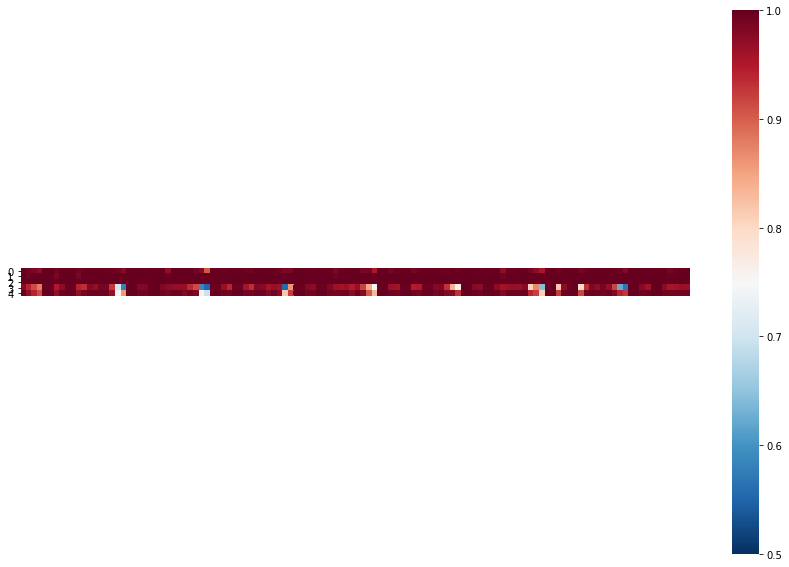

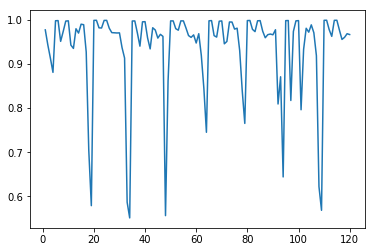

111


In [64]:
# print(icc_vals_fold)
print(samples.shape)
print(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)))
import seaborn as sns
f, ax = plt.subplots(figsize=(15, 10))
# Draw the heatmap using seaborn
sns.heatmap(icc_vals_fold.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1)
plt.show()

minICC = np.nanmin(icc_vals_fold,axis = 1)

# Draw the heatmap using seaborn
plt.plot( range(1, icc_vals_fold.shape[0] +1),  minICC) 
plt.show()

minICC[np.isnan(minICC)] = 0
np.save(os.path.join(fold_dir,'tda_feature_minICC.npy'),minICC)
print(np.count_nonzero(minICC>.75))

(120, 5, 10)
['R', 'N', 'T', 'V', 'C']


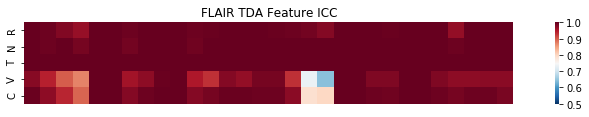

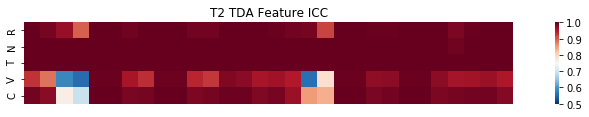

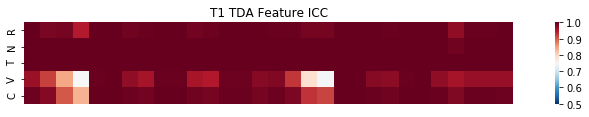

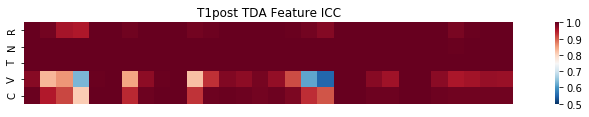

In [70]:
import pandas as pd
print(icc_vals2.shape)
print(cases)
nFeat = np.int(icc_vals2.shape[0]/len(modal_list))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals2[idxs,:,:],axis = 2)
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
    f, ax = plt.subplots(figsize=(15, 1.5))
    # Draw the heatmap using seaborn
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
        '%s TDA Feature ICC' % (modal))
    plt.show()

In [72]:
print(np.count_nonzero(minICC2 < .75))
print(np.count_nonzero(minICC2 < .75)/len(minICC2))
print(np.count_nonzero(minICC2 < .90))
print(np.count_nonzero(minICC2 < .90)/len(minICC2))
print(np.mean(icc_vals2[:,:,0], axis=0))

9
0.075
18
0.15
[0.99435305 0.9993844  1.         0.93667906 0.97528209]


In [71]:
minCT = np.zeros((10,1))
for i in range(10):
    minICC2 = np.nanmin(icc_vals2[:,:,i],axis = 1)
    minCT[i] = np.count_nonzero(minICC2<=.75)
#     print(minCT[i])
print(np.mean(minCT))
print(np.count_nonzero(np.logical_not(np.isnan(minICC2))))

print(np.mean(minCT)/np.count_nonzero(np.logical_not(np.isnan(minICC2))))
print(np.count_nonzero((minICC2<=.75) & np.logical_not(np.isnan(minICC2))))

9.7
120
0.08083333333333333
9


(120, 5, 10)
['R', 'N', 'T', 'V', 'C']


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


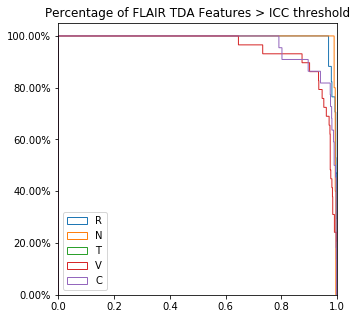

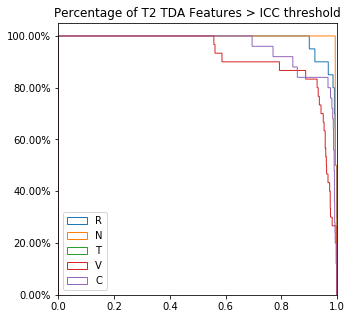

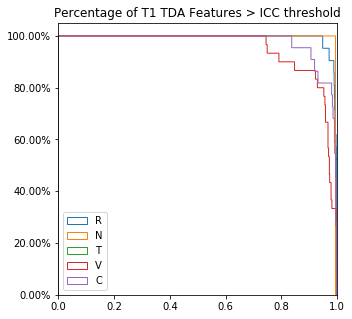

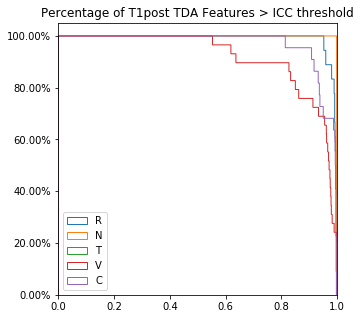

In [75]:

print(icc_vals2.shape)
print(cases)
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)
nFeat = np.int(icc_vals2.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),nFeat,len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals2[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
#     f, ax = plt.subplots(figsize=(15, 1.5))
#     # Draw the heatmap using seaborn
#     sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
#         '%s CNN Feature ICC' % (modal))
#     plt.show()
    f, ax = plt.subplots(figsize=(5,5))
    plt.xlim(0,1)
    plt.title('Percentage of %s TDA Features > ICC threshold' % (modal))
    # Draw the heatmap using seaborn
    for cI in range(mICC.shape[1]):
        plt.hist(mICC[:,cI],bins = np.arange(0,1,.001),histtype = 'step',density = 'true',cumulative = -1,label = cases[cI])
#         sns.distplot(mICC[:,cI], hist_kws=dict(cumulative=-1))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.legend(loc = 'lower left')
    plt.savefig(os.path.join(outImDir,'tda_ICC_Perc_Curve_%s.png' % (modal)))
    plt.show()
#     print(feature_names_all[i])
    

In [76]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals3 = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        case = cases[prtI]
        tau_vec = case_tau[case]
        if case == 'V':
            idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
        else:
            idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(list(range(len(tr_id))), len(idxs),1).T.ravel()
        for ftN in range(samples.shape[1]):
            if (ftN % 100) == 0: 
                print('%d %d %d - ' % (fold_num, prtI,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals3[:,:,fold_num] = icc_vals_fold
    minICC3 = np.nanmin(icc_vals_fold,axis = 1)
    minICC3[np.isnan(minICC3)] = 0
    np.save(os.path.join(fold_dir,'tda_feature_min_icc3.npy'),minICC3)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 0 0 -  17:34:33.051374
0 0 100 -  17:34:34.382904
0 1 0 -  17:34:34.619532
0 1 100 -  17:34:35.821363
0 2 0 -  17:34:36.062008
0 2 100 -  17:34:36.869150
0 3 0 -  17:34:37.029576
0 3 100 -  17:34:37.831731
0 4 0 -  17:34:37.994135
0 4 100 -  17:34:39.277539
1 0 0 -  17:34:39.582349
1 0 100 -  17:34:40.790267
1 1 0 -  17:34:41.058980
1 1 100 -  17:34:42.460699
1 2 0 -  17:34:42.720388
1 2 100 -  17:34:43.569673
1 3 0 -  17:34:43.753127
1 3 100 -  17:34:44.649534
1 4 0 -  17:34:44.822998
1 4 100 -  17:34:46.143504
2 0 0 -  17:34:46.448278
2 0 100 -  17:34:47.790840
2 1 0 -  17:34:48.057549
2 1 100 -  17:34:49.488992
2 2 0 -  17:34:49.773719
2 2 100 -  17:34:50.723124
2 3 0 -  17:34:50.907626
2 3 100 -  17:34:51.836074
2 4 0 -  17:34:52.021568
2 4 100 -  17:34:53.460547
3 0 0 -  17:34:53.799414
3 0 100 -  17:34:55.183085
3 1 0 -  17:34:55.469845
3 1 100 -  17:34:57.065608
3 2 0 -  17:34:57.419547
3 2 100 -  17:34:58.375082
3 3 0 -  17:34:58.566591
3 3 100 -  17:34:59.535160
3 4 0 -  17:

(120, 5, 10)
['R', 'N', 'T', 'V', 'C']


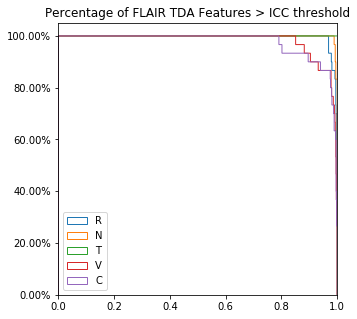

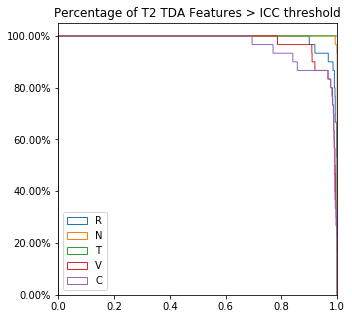

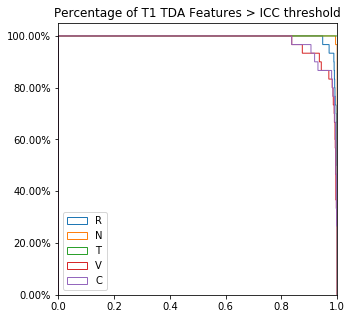

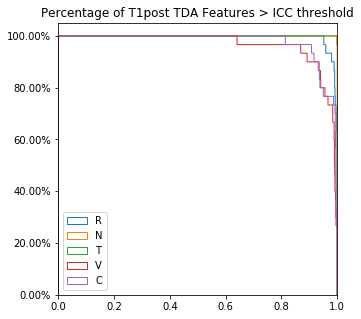

In [82]:

print(icc_vals3.shape)
print(cases)
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)
nFeat = np.int(icc_vals3.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),nFeat,len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals3[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
#     f, ax = plt.subplots(figsize=(15, 1.5))
#     # Draw the heatmap using seaborn
#     sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
#         '%s CNN Feature ICC' % (modal))
#     plt.show()
    f, ax = plt.subplots(figsize=(5,5))
    plt.xlim(0,1)
    plt.title('Percentage of %s TDA Features > ICC threshold' % (modal))
    # Draw the heatmap using seaborn
    for cI in range(mICC.shape[1]):
        plt.hist(mICC[:,cI],bins = np.arange(0,1.01,.001),histtype = 'step',density = 'true',cumulative = -1,label = cases[cI])
#         sns.distplot(mICC[:,cI], hist_kws=dict(cumulative=-1))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.legend(loc = 'lower left')
    plt.savefig(os.path.join(outImDir,'tda_ICC_Perc_Curve_%s_icc3.png' % (modal)))
    plt.show()
#     print(feature_names_all[i])
    

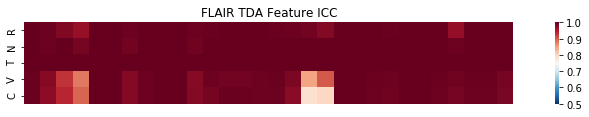

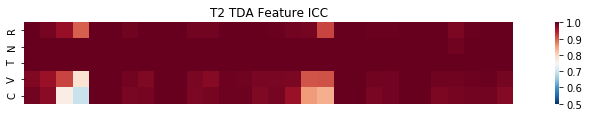

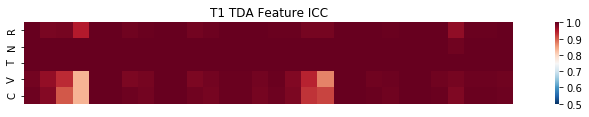

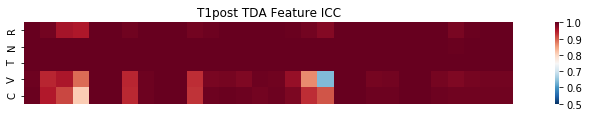

In [78]:
nFeat = np.int(icc_vals3.shape[0]/len(modal_list))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals3[idxs,:,:],axis = 2)
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
    f, ax = plt.subplots(figsize=(15, 1.5))
    # Draw the heatmap using seaborn
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
        '%s TDA Feature ICC' % (modal))
    plt.savefig(os.path.join(outImDir,'tda_ICC_heatmap_%s_icc3.png' % (modal)))
    plt.show()

In [81]:
minCT = np.zeros((10,1))
minCT_9 = np.zeros((10,1))
for i in range(10):
    minICC3 = np.nanmin(icc_vals3[:,:,i],axis = 1)
    minCT[i] = np.count_nonzero(minICC3<=.75)
    minCT_9[i] = np.count_nonzero(minICC3<=.9)
#     print(minCT[i])
print(np.mean(minCT))
print(np.count_nonzero(np.logical_not(np.isnan(minICC3))))

print(np.mean(minCT)/np.count_nonzero(np.logical_not(np.isnan(minICC3))))
print(np.count_nonzero((minICC3<=.75) & np.logical_not(np.isnan(minICC3))))
print(np.mean(minCT_9)/np.count_nonzero(np.logical_not(np.isnan(minICC3))))
print(np.count_nonzero((minICC3<=.9) & np.logical_not(np.isnan(minICC3))))

2.9
120
0.024166666666666666
2
0.09666666666666666
11
